In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
!pip install category_encoders

     |████████████████████████████████| 81kB 4.9MB/s 


In [ ]:
from category_encoders import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = 'gdrive/My Drive/Hackaton BBVA/Datos/'

In [ ]:
def graficar_probabilidades(probabilidades, y_test):
    df = pd.DataFrame(list(zip(probabilidades, y_test)), columns =['Probabilidad', 'Y'])
    plt.figure(figsize=(15,5))
    sns.distplot(df[df['Y']==0][['Probabilidad']].dropna(), hist=False, label='0')
    sns.distplot(df[df['Y']==1][['Probabilidad']].dropna(), hist=False, label='1')

### Subir datos

In [ ]:
ranking = pd.read_csv(path+'dbRanking.csv', delimiter = '|')
dbAfilDigital = pd.read_csv(path+'dbAfilDigital.csv', delimiter = '|')
sunat = pd.read_csv(path+'dbSunat.csv', delimiter = '|')
dbSunarp = pd.read_csv(path+'dbSunarp.csv', delimiter = '|')
#dbRcc = pd.read_csv(path+'dbRcc.csv', delimiter = '|')
dbUniverso = pd.read_csv(path+'dbUniverso.csv', delimiter = '|',low_memory=False)
dbTransacPyme = pd.read_csv(path+'dbTransacPyme_v2.csv', delimiter = '|')

In [ ]:
dbRcc = pd.read_csv(path+'dbRcc.csv', delimiter = '|')

In [ ]:
ranking.shape # 5952

(13319, 226)

In [ ]:
dbAfilDigital.shape # 28090

(28090, 8)

In [ ]:
sunat.shape # 260732

(260738, 8)

In [ ]:
dbSunarp.shape #19856

(23397, 9)

In [ ]:
dbTransacPyme.shape # 13023197

(14963858, 7)

In [ ]:
dbRcc.shape # 7961768

(7962068, 8)

In [ ]:
dbUniverso.shape # 268804

(268804, 12)

### Eliminar duplicados

In [ ]:
sunat.drop_duplicates(inplace = True)
ranking.drop_duplicates(inplace = True)
dbAfilDigital.drop_duplicates(inplace = True)
dbSunarp.drop_duplicates(inplace = True)


In [ ]:
dbRcc.drop_duplicates(inplace = True)

In [ ]:
dbUniverso.drop_duplicates(inplace = True)

In [ ]:
dbTransacPyme.shape

(14963858, 7)

In [ ]:
dbTransacPyme.drop_duplicates(inplace = True)

dbUniverso

In [ ]:
dbUniverso.drop_duplicates(['taxpayer_id'], keep = 'first', inplace = True)

In [ ]:
dbUniverso = dbUniverso[dbUniverso['taxpayer_id'] != '914323    J'].copy()

In [ ]:
dbUniverso['taxpayer_id'] = dbUniverso['taxpayer_id'].apply(lambda x : int(x))

ranking

In [ ]:
ranking.drop_duplicates(['taxpayer_id'], keep = 'last', inplace = True)

In [ ]:
ranking.rename(columns = {'company_economic_activity_id' : 'company_economic_activity_id_ranking'} , inplace = True)

dbSunarp

In [ ]:
dbSunarp['Fecha_registro'] = dbSunarp['ownership_issued_date'].apply(lambda x: str(x)[0:10])
dbSunarp['Fecha_registro'] = pd.to_datetime(dbSunarp['Fecha_registro'])
dbSunarp['cutoff_date'] = pd.to_datetime(dbSunarp['cutoff_date'])

In [ ]:
dbSunarp['Diferencia_meses_registro'] = (dbSunarp['cutoff_date'] - dbSunarp['Fecha_registro'])/np.timedelta64(1,'M')
dbSunarp['Anios_vehiculos'] = 2020-dbSunarp['vehicle_manufacture_year_id']

In [ ]:
dbSunarp.head()

,personal_type,personal_id,ownership_issued_date,ownership_registry_type,vehicle_chassis_type,vehicle_class_type,vehicle_manufacture_year_id,transferred_number,cutoff_date,Fecha_registro,Diferencia_meses_registro,Anios_vehiculos
0,L,760213,2011-03-23T00:00:00.000Z,Inscripci�n de Veh�culo - Primera Inscripci�n ...,SUV,CMTA RURAL,2010.0,1.0,2020-02-29,2011-03-23,107.271197,10.0
1,L,26821041,NaN,NaN,MOTOCICLETA,VEH. AUT. MEN.,2003.0,1.0,2020-02-29,NaT,NaN,17.0
2,L,27002525,2011-02-03T00:00:00.000Z,Inscripci�n de Veh�culo - Primera Inscripci�n ...,MOTOCICLETA,VEH. AUT. MEN.,2010.0,1.0,2020-02-29,2011-02-03,108.848231,10.0
3,L,71363528,2015-01-21T00:00:00.000Z,Inscripci�n de Veh�culo - Primera Inscripci�n ...,MULTIPROPOSITO,CMTA RURAL,2014.0,1.0,2020-02-29,2015-01-21,61.274359,6.0
4,R,14001436656,2001-05-14T00:00:00.000Z,NaN,MOTOCICLETA,VEH. AUT. MEN.,1996.0,2.0,2020-02-29,2001-05-14,225.548779,24.0


In [ ]:
def cambiar_registro(x):
    if x in ['Transferencia de Propiedad - Compra - Venta']:
        return 'Compra_venta'
    elif x in ['Inscripci�n de Veh�culo - Primera Inscripci�n de Dominio']:
        return 'Primera_inscripcion'
    elif x =='NOID':
        return 'NOID'
    else:
        return 'Otros'   

In [ ]:
dbSunarp['ownership_registry_type'].fillna('NOID',inplace=True)
dbSunarp['ownership_registry_type'] = dbSunarp['ownership_registry_type'].apply(lambda x: cambiar_registro(x))

In [ ]:
def cambiar_tipo_vehiculo(x):
    if x in ['SEDAN','NOID','BARANDA','MOTOCICLETA','SUV','STATION WAGON','PICK UP','METROPOLITANO','TRIMOTO PASAJEROS','CABINA SIMPLE','FURGON','VOLQUETE','NO METROPOLITANO','PLATAFORMA','MICROBUS','HATCHBACK','MULTIPROPOSITO','REMOLCADOR','CABINA DOBLE','TRIMOTO CARGA']:
        return x
    else:
        return 'Otros'

In [ ]:
dbSunarp['vehicle_chassis_type'].fillna('NOID',inplace=True)
dbSunarp['vehicle_chassis_type'] = dbSunarp['vehicle_chassis_type'].apply(lambda x: cambiar_tipo_vehiculo(x))

In [ ]:
def cambiar_tipo_vehiculo_2(x):
    if x in ['AUTOMOVIL','VEH. AUT. MEN.','CMTA RURAL','CMTA PICKUP','CAMION','STAT. WAGON','S/C','NOID']:
        return x
    else:
        return 'Otros'

In [ ]:
dbSunarp['vehicle_class_type'].fillna('NOID',inplace=True)
dbSunarp['vehicle_class_type'] = dbSunarp['vehicle_class_type'].apply(lambda x: cambiar_tipo_vehiculo_2(x))

In [ ]:
dbSunarp = pd.get_dummies(data=dbSunarp, columns=['ownership_registry_type','vehicle_chassis_type','vehicle_class_type'])

In [ ]:
agr = {}

agregados_porcentajes = ['sum']
for columna in ['ownership_registry_type_Compra_venta', 'ownership_registry_type_NOID', 'ownership_registry_type_Otros','ownership_registry_type_Primera_inscripcion', 'vehicle_chassis_type_BARANDA', 'vehicle_chassis_type_CABINA DOBLE', 'vehicle_chassis_type_CABINA SIMPLE', 'vehicle_chassis_type_FURGON', 'vehicle_chassis_type_HATCHBACK', 'vehicle_chassis_type_METROPOLITANO', 'vehicle_chassis_type_MICROBUS', 'vehicle_chassis_type_MOTOCICLETA', 'vehicle_chassis_type_MULTIPROPOSITO','vehicle_chassis_type_NO METROPOLITANO', 'vehicle_chassis_type_NOID','vehicle_chassis_type_Otros', 'vehicle_chassis_type_PICK UP','vehicle_chassis_type_PLATAFORMA', 'vehicle_chassis_type_REMOLCADOR','vehicle_chassis_type_SEDAN', 'vehicle_chassis_type_STATION WAGON','vehicle_chassis_type_SUV', 'vehicle_chassis_type_TRIMOTO CARGA','vehicle_chassis_type_TRIMOTO PASAJEROS','vehicle_chassis_type_VOLQUETE', 'vehicle_class_type_AUTOMOVIL','vehicle_class_type_CAMION', 'vehicle_class_type_CMTA PICKUP','vehicle_class_type_CMTA RURAL', 'vehicle_class_type_NOID','vehicle_class_type_Otros', 'vehicle_class_type_S/C','vehicle_class_type_STAT. WAGON', 'vehicle_class_type_VEH. AUT. MEN.']:
    agr.update({columna: agregados_porcentajes})

agregados_porcentajes = ['max','min','mean']
for columna in ['transferred_number','Diferencia_meses_registro','Anios_vehiculos']:
    agr.update({columna: agregados_porcentajes})
    
agregados_porcentajes = ['count']
for columna in ['personal_type']:
    agr.update({columna: agregados_porcentajes})

dbSunarp_agr=dbSunarp.groupby(['personal_id']).agg(agr).reset_index()
dbSunarp_agr.columns=[x[0]+'_'+x[1] if x[0] not in ['personal_id'] else x[0] for x in dbSunarp_agr.columns]

dbSunarp_agr.head()

,personal_id,ownership_registry_type_Compra_venta_sum,ownership_registry_type_NOID_sum,ownership_registry_type_Otros_sum,ownership_registry_type_Primera_inscripcion_sum,vehicle_chassis_type_BARANDA_sum,vehicle_chassis_type_CABINA DOBLE_sum,vehicle_chassis_type_CABINA SIMPLE_sum,vehicle_chassis_type_FURGON_sum,vehicle_chassis_type_HATCHBACK_sum,vehicle_chassis_type_METROPOLITANO_sum,vehicle_chassis_type_MICROBUS_sum,vehicle_chassis_type_MOTOCICLETA_sum,vehicle_chassis_type_MULTIPROPOSITO_sum,vehicle_chassis_type_NO METROPOLITANO_sum,vehicle_chassis_type_NOID_sum,vehicle_chassis_type_Otros_sum,vehicle_chassis_type_PICK UP_sum,vehicle_chassis_type_PLATAFORMA_sum,vehicle_chassis_type_REMOLCADOR_sum,vehicle_chassis_type_SEDAN_sum,vehicle_chassis_type_STATION WAGON_sum,vehicle_chassis_type_SUV_sum,vehicle_chassis_type_TRIMOTO CARGA_sum,vehicle_chassis_type_TRIMOTO PASAJEROS_sum,vehicle_chassis_type_VOLQUETE_sum,vehicle_class_type_AUTOMOVIL_sum,vehicle_class_type_CAMION_sum,vehicle_class_type_CMTA PICKUP_sum,vehicle_class_type_CMTA RURAL_sum,vehicle_class_type_NOID_sum,vehicle_class_type_Otros_sum,vehicle_class_type_S/C_sum,vehicle_class_type_STAT. WAGON_sum,vehicle_class_type_VEH. AUT. MEN._sum,transferred_number_max,transferred_number_min,transferred_number_mean,Diferencia_meses_registro_max,Diferencia_meses_registro_min,Diferencia_meses_registro_mean,Anios_vehiculos_max,Anios_vehiculos_min,Anios_vehiculos_mean,personal_type_count
0,20048,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN,31.672108,31.672108,31.672108,NaN,NaN,NaN,1
1,25152,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN,29.569396,29.569396,29.569396,NaN,NaN,NaN,1
2,26401,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN,38.801618,38.801618,38.801618,NaN,NaN,NaN,1
3,26485,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,2,0,1,0,0,0,0,0,0,3.0,1.0,2.333333,203.207458,186.812871,195.333238,52.0,35.0,44.333333,3
4,37469,7,0,0,0,0,0,0,0,5,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,4.0,2.0,2.571429,103.887143,81.447258,87.886815,13.0,10.0,11.285714,7


RCC

In [ ]:
dbRcc_v1 = pd.merge (dbRcc,dbUniverso[['customer_id','sbs_customer_id']], on = 'sbs_customer_id' , how = 'left')
dbRcc_v1 = dbRcc_v1[dbRcc_v1.customer_id.isnull() == False].copy()
dbRcc_v1 = dbRcc_v1[dbRcc_v1.producto != 'Descuento'].copy()
dbRcc_max = dbRcc_v1[['sbs_customer_id','cutoff_date']].groupby('sbs_customer_id').max().reset_index()
dbRcc_max['Ultimo_corte'] = 1
dbRcc_v2 = pd.merge (dbRcc_v1,dbRcc_max, on = ['sbs_customer_id','cutoff_date'] , how = 'left')
dbRcc_v2.Ultimo_corte.fillna(0,inplace=True)

In [ ]:
def entidad_sbs(x):
    if x in [49279,90846,34470,53565,1392,42477,12763,66532,10300,97813]:
        return x
    else:
        return 'Otro'

In [ ]:
dbRcc_v2['sbs_entity_id'] = dbRcc_v2['sbs_entity_id'].apply(lambda x: entidad_sbs(x))

In [ ]:
def producto(x):
    if x in ['Préstamo de Libre Disponibilidad','Tarjeta de Crédito','Leasing','Cuenta Corriente']:
        return x
    else:
        return 'Otros'

In [ ]:
dbRcc_v2['producto'] = dbRcc_v2['producto'].apply(lambda x: producto(x))

In [ ]:
dbRcc_v3 = dbRcc_v2[dbRcc_v2['Ultimo_corte']==1].copy()

In [ ]:
dbRcc_v3_sbs_entity_id = pd.pivot_table(dbRcc_v3, values='balance_amount', index=['sbs_customer_id'], columns=['sbs_entity_id'], aggfunc=[np.sum,len],fill_value=0).reset_index()
dbRcc_v3_sbs_entity_id.columns=[str(x[0])+'_'+str(x[1]) if x[0] not in ['sbs_customer_id'] else x[0] for x in dbRcc_v3_sbs_entity_id.columns]

dbRcc_v3_producto = pd.pivot_table(dbRcc_v3, values='balance_amount', index=['sbs_customer_id'], columns=['producto'], aggfunc=[np.sum,len],fill_value=0).reset_index()
dbRcc_v3_producto.columns=[str(x[0])+'_'+str(x[1]) if x[0] not in ['sbs_customer_id'] else x[0] for x in dbRcc_v3_producto.columns]

dbRcc_v3_situacion_credito = pd.pivot_table(dbRcc_v3, values='balance_amount', index=['sbs_customer_id'], columns=['situacion_credito'], aggfunc=[np.sum,len],fill_value=0).reset_index()
dbRcc_v3_situacion_credito.columns=[str(x[0])+'_'+str(x[1]) if x[0] not in ['sbs_customer_id'] else x[0] for x in dbRcc_v3_situacion_credito.columns]

In [ ]:
agr = {}

agregados_porcentajes = ['max','min','sum','mean']
for columna in ['balance_amount']:
    agr.update({columna: agregados_porcentajes})
    
agregados_porcentajes = ['sum']
for columna in ['num_days_default_payment_number']:
    agr.update({columna: agregados_porcentajes})

In [ ]:
sbs_customer_id_agr=dbRcc_v3.groupby(['sbs_customer_id']).agg(agr).reset_index()
sbs_customer_id_agr.columns=[x[0]+'_'+x[1] if x[0] not in ['sbs_customer_id'] else x[0] for x in sbs_customer_id_agr.columns]

In [ ]:
sbs_customer_id_agr = pd.merge(sbs_customer_id_agr,dbRcc_v3_sbs_entity_id, how='left',on='sbs_customer_id')
sbs_customer_id_agr = pd.merge(sbs_customer_id_agr,dbRcc_v3_producto, how='left',on='sbs_customer_id')
sbs_customer_id_agr = pd.merge(sbs_customer_id_agr,dbRcc_v3_situacion_credito, how='left',on='sbs_customer_id')

Target

In [ ]:
dbRcc_v2['Flag_Credito'] = 0
dbRcc_v2.loc[dbRcc_v2.situacion_credito == 'VIGENTE', 'Flag_Credito'] = 1
dbRcc_target = dbRcc_v2[dbRcc_v2['Ultimo_corte']==1][['sbs_customer_id','Flag_Credito']].groupby('sbs_customer_id').min().reset_index()

In [ ]:
dbRcc_target_monto = dbRcc_v3.groupby('sbs_customer_id')['balance_amount'].sum().reset_index()

In [ ]:
dbRcc_target_monto.describe()

,sbs_customer_id,balance_amount
count,3.259400e+04,3.259400e+04
mean,4.989685e+09,3.407707e+05
std,2.903818e+09,1.090040e+06
min,1.000139e+06,1.000000e-02
25%,2.472658e+09,2.906578e+04
50%,4.978263e+09,1.035802e+05
75%,7.522279e+09,3.285462e+05
max,9.999861e+09,8.340427e+07


In [ ]:
dbRcc_target.Flag_Credito.value_counts()*100/len(dbRcc_target)

1    87.144873
0    12.855127
Name: Flag_Credito, dtype: float64

In [ ]:
dbRcc_target_monto.head()

,sbs_customer_id,balance_amount
0,1000139,134111.63
1,1732105,781076.96
2,1768488,174340.00
3,2039560,167103.67
4,2195590,34.68


data_final

In [ ]:
data_final = pd.merge (dbUniverso, sunat[['taxpayer_id','taxpayer_start_date','taxpayer_end_date','comm_start_date','company_economic_activity_id']], on = 'taxpayer_id' , how = 'left')

In [ ]:
data_final.shape #(268798, 16)

(268797, 16)

In [ ]:
data_final = pd.merge(data_final, ranking, on = 'taxpayer_id' , how = 'left')

In [ ]:
data_final.shape

(268797, 241)

In [ ]:
data_final = pd.merge(data_final, dbAfilDigital[['customer_id','digital_affiliation_type','digital_affiliation_date','online_banking_affiliation_type','online_banking_affiliation_date','sms_affiliation_type','sms_affiliation_date']], on = 'customer_id' , how = 'left')

In [ ]:
data_final.shape #(268798, 247)

(268797, 247)

#### dbTransacPyme

In [ ]:
dbTransacPyme_agg=dbTransacPyme.groupby('COD_PERSONOR',as_index=False).agg(
                                                                  {'COD_PERSONDE': ['count', 'nunique'],
                                                                   'IDW_CANAL':['nunique'],
                                                                   'COD_TRANSAC':['nunique'],
                                                                   'FEC_OPER':['max','nunique'],
                                                                   'IMP_IMPOPER':['mean','std','max','sum','min']
                                                                  } 
                                                                   )

In [ ]:
dbTransacPyme_agg.columns=["_".join(x) for x in dbTransacPyme_agg.columns.ravel()]

In [ ]:
dbTransacPyme_agg.head()

,COD_PERSONOR_,COD_PERSONDE_count,COD_PERSONDE_nunique,IDW_CANAL_nunique,COD_TRANSAC_nunique,FEC_OPER_max,FEC_OPER_nunique,IMP_IMPOPER_mean,IMP_IMPOPER_std,IMP_IMPOPER_max,IMP_IMPOPER_sum,IMP_IMPOPER_min
0,509.0,96,13,1,7,31/12/2019,59,777.167387,1040.675987,8651.0,86265.58,20.0
1,1060.0,0,0,1,2,28/10/2019,5,180.600000,187.621427,500.0,903.00,20.0
2,2040.0,0,0,2,6,31/12/2019,58,1036.936975,2189.886156,10000.0,123395.50,10.0
3,2258.0,143,12,1,5,31/01/2020,45,449.254091,213.625882,1280.0,69185.13,48.0
4,4069.0,11,4,1,2,31/01/2020,44,407.090833,677.810622,5000.0,34195.63,20.0


In [ ]:
dbTransacPyme_COD_PERSONDE_agg=dbTransacPyme.groupby('COD_PERSONDE',as_index=False).agg(
                                                                  {'COD_PERSONOR': ['count', 'nunique'],
                                                                   'IDW_CANAL':['nunique'],
                                                                   'COD_TRANSAC':['nunique'],
                                                                   'FEC_OPER':['max','nunique'],
                                                                   'IMP_IMPOPER':['mean','std','max','sum','min']
                                                                  } 
                                                                   )

In [ ]:
dbTransacPyme_COD_PERSONDE_agg.columns=["_".join(x) for x in dbTransacPyme_COD_PERSONDE_agg.columns.ravel()]

In [ ]:
dbTransacPyme_COD_PERSONDE_agg.rename(columns = {'COD_PERSONDE_' : 'customer_id',
                                                 'COD_PERSONOR_count' : 'Qty_Transacciones'} , inplace = True) 

In [ ]:
dbTransacPyme_agg.rename(columns = {'COD_PERSONOR_' : 'customer_id',
                                   'COD_PERSONDE_count' : 'Qty_Transacciones'} , inplace = True) 

In [ ]:
dbTransacPyme_COD_PERSONDE_agg.columns=[x+ "_De" for x in dbTransacPyme_COD_PERSONDE_agg.columns.ravel()]

In [ ]:
dbTransacPyme_agg.columns=[x+ "_Or" for x in dbTransacPyme_agg.columns.ravel()]

In [ ]:
dbTransacPyme_COD_PERSONDE_agg.rename(columns = {'customer_id_De' : 'customer_id'} , inplace = True) 

In [ ]:
dbTransacPyme_agg.rename(columns = {'customer_id_Or' : 'customer_id'} , inplace = True) 

In [ ]:
dbTransacPyme_COD_PERSONDE_agg.head()

,customer_id,Qty_Transacciones_De,COD_PERSONOR_nunique_De,IDW_CANAL_nunique_De,COD_TRANSAC_nunique_De,FEC_OPER_max_De,FEC_OPER_nunique_De,IMP_IMPOPER_mean_De,IMP_IMPOPER_std_De,IMP_IMPOPER_max_De,IMP_IMPOPER_sum_De,IMP_IMPOPER_min_De
0,83.0,14,1,1,1,30/12/2019,13,595.371429,292.028775,887.3,8335.20,103.50
1,324.0,22,1,1,1,31/10/2019,20,1051.818182,672.110793,2483.0,23140.00,20.00
2,375.0,4,1,1,1,23/01/2020,4,2191.440000,2073.082980,5200.0,8765.76,607.76
3,448.0,3,1,1,1,30/12/2019,3,1433.333333,115.470054,1500.0,4300.00,1300.00
4,509.0,31,4,1,1,31/05/2020,28,701.496774,1077.176945,3115.0,21746.40,177.00


In [ ]:
dbTransacPyme_agg.head()

,customer_id,Qty_Transacciones_Or,COD_PERSONDE_nunique_Or,IDW_CANAL_nunique_Or,COD_TRANSAC_nunique_Or,FEC_OPER_max_Or,FEC_OPER_nunique_Or,IMP_IMPOPER_mean_Or,IMP_IMPOPER_std_Or,IMP_IMPOPER_max_Or,IMP_IMPOPER_sum_Or,IMP_IMPOPER_min_Or
0,509.0,96,13,1,7,31/12/2019,59,777.167387,1040.675987,8651.0,86265.58,20.0
1,1060.0,0,0,1,2,28/10/2019,5,180.600000,187.621427,500.0,903.00,20.0
2,2040.0,0,0,2,6,31/12/2019,58,1036.936975,2189.886156,10000.0,123395.50,10.0
3,2258.0,143,12,1,5,31/01/2020,45,449.254091,213.625882,1280.0,69185.13,48.0
4,4069.0,11,4,1,2,31/01/2020,44,407.090833,677.810622,5000.0,34195.63,20.0


In [ ]:
dbTransacPyme_COD_PERSONDE_agg['FEC_OPER_max_De'] = pd.to_datetime(dbTransacPyme_COD_PERSONDE_agg.FEC_OPER_max_De)

In [ ]:
dbTransacPyme_agg['FEC_OPER_max_Or'] = pd.to_datetime(dbTransacPyme_agg.FEC_OPER_max_Or)

In [ ]:
dbTransacPyme_agg.head()

,customer_id,Qty_Transacciones_Or,COD_PERSONDE_nunique_Or,IDW_CANAL_nunique_Or,COD_TRANSAC_nunique_Or,FEC_OPER_max_Or,FEC_OPER_nunique_Or,IMP_IMPOPER_mean_Or,IMP_IMPOPER_std_Or,IMP_IMPOPER_max_Or,IMP_IMPOPER_sum_Or,IMP_IMPOPER_min_Or
0,509.0,96,13,1,7,2019-12-31,59,777.167387,1040.675987,8651.0,86265.58,20.0
1,1060.0,0,0,1,2,2019-10-28,5,180.600000,187.621427,500.0,903.00,20.0
2,2040.0,0,0,2,6,2019-12-31,58,1036.936975,2189.886156,10000.0,123395.50,10.0
3,2258.0,143,12,1,5,2020-01-31,45,449.254091,213.625882,1280.0,69185.13,48.0
4,4069.0,11,4,1,2,2020-01-31,44,407.090833,677.810622,5000.0,34195.63,20.0


In [ ]:
dbTransacPyme_COD_PERSONDE_agg.head()

,customer_id,Qty_Transacciones_De,COD_PERSONOR_nunique_De,IDW_CANAL_nunique_De,COD_TRANSAC_nunique_De,FEC_OPER_max_De,FEC_OPER_nunique_De,IMP_IMPOPER_mean_De,IMP_IMPOPER_std_De,IMP_IMPOPER_max_De,IMP_IMPOPER_sum_De,IMP_IMPOPER_min_De
0,83.0,14,1,1,1,2019-12-30,13,595.371429,292.028775,887.3,8335.20,103.50
1,324.0,22,1,1,1,2019-10-31,20,1051.818182,672.110793,2483.0,23140.00,20.00
2,375.0,4,1,1,1,2020-01-23,4,2191.440000,2073.082980,5200.0,8765.76,607.76
3,448.0,3,1,1,1,2019-12-30,3,1433.333333,115.470054,1500.0,4300.00,1300.00
4,509.0,31,4,1,1,2020-05-31,28,701.496774,1077.176945,3115.0,21746.40,177.00


#### Tratamiento de Datos

In [ ]:
data_final_le = data_final[['personal_type','personal_id','customer_id','sbs_customer_id','taxpayer_id','segmento','gender_type','birth_date','marital_status_type','admission_date','income_monthly_amount','taxpayer_start_date','comm_start_date','company_economic_activity_id','ciiu_spanish_desc','spanish_sector_company_name','employees_number','branches_number',
            'activity_start_date','seniority_company_years_number','company_size_desc','foreign_company_mark_type','department_name','private_public_mark_desc','market_share_per',
            'ranking_2017_number','ranking_2016_number','ranking_2015_number','ranking_2014_number','ranking_2013_number','ranking_2012_number','ranking_2011_number','ranking_2010_number','min_usd_billing_2017_amount','min_usd_billing_2016_amount','min_usd_billing_2015_amount','min_usd_billing_2014_amount','min_usd_billing_2013_amount','max_usd_billing_2017_amount',
            'max_usd_billing_2016_amount','max_usd_billing_2015_amount','max_usd_billing_2014_amount','max_usd_billing_2013_amount','min_pen_billing_2017_amount','min_pen_billing_2016_amount','min_pen_billing_2015_amount','min_pen_billing_2014_amount','min_pen_billing_2013_amount','max_pen_billing_2017_amount','max_pen_billing_2016_amount','max_pen_billing_2015_amount','max_pen_billing_2014_amount',
            'max_pen_billing_2013_amount','income_2017_amount','income_2016_amount','income_2015_amount','income_2014_amount','income_2013_amount','income_2012_amount','income_2011_amount','income_2010_amount','income_2009_amount','income_2008_amount','income_2007_amount','income_2006_amount','income_2005_amount','income_2004_amount','income_2003_amount','income_2002_amount','income_2001_amount',
            'income_2000_amount','net_profit_2017_amount','net_profit_2016_amount','net_profit_2015_amount','net_profit_2014_amount','net_profit_2013_amount','net_profit_2012_amount','net_profit_2011_amount','net_profit_2010_amount','net_profit_2009_amount','net_profit_2008_amount','net_profit_2007_amount','net_profit_2006_amount','net_profit_2005_amount','net_profit_2004_amount','net_profit_2003_amount',
            'net_profit_2002_amount','net_profit_2001_amount','net_profit_2000_amount','assets_2016_amount','assets_2015_amount','assets_2014_amount','assets_2013_amount','assets_2012_amount','assets_2011_amount','assets_2010_amount','assets_2009_amount','assets_2008_amount','assets_2007_amount','assets_2006_amount','assets_2005_amount','assets_2004_amount','assets_2003_amount','assets_2002_amount',
            'assets_2001_amount','assets_2000_amount','equity_2016_amount','equity_2015_amount','equity_2014_amount','equity_2013_amount','equity_2012_amount','equity_2011_amount','equity_2010_amount','equity_2009_amount','equity_2008_amount','equity_2007_amount','equity_2006_amount','equity_2005_amount','equity_2004_amount','equity_2003_amount','equity_2002_amount','equity_2001_amount','equity_2000_amount',
            'liabilities_2016_amount','liabilities_2015_amount','liabilities_2014_amount','liabilities_2013_amount','liabilities_2012_amount','liabilities_2011_amount','liabilities_2010_amount','liabilities_2009_amount','liabilities_2008_amount','liabilities_2007_amount',
            'liabilities_2006_amount','liabilities_2005_amount','liabilities_2004_amount','liabilities_2003_amount','liabilities_2002_amount','liabilities_2001_amount','exporter_mark_type','usd_export_2017_amount','usd_export_2016_amount','usd_export_2015_amount','usd_export_2014_amount','usd_export_2013_amount','usd_export_2012_amount','usd_export_2011_amount','usd_export_2010_amount','usd_export_2009_amount','usd_export_2008_amount','usd_export_2007_amount',
            'usd_export_2006_amount','usd_export_2005_amount','usd_export_2004_amount','usd_export_2003_amount','usd_export_2002_amount','usd_export_2001_amount','usd_export_2000_amount','usd_export_1999_amount','usd_export_1998_amount','usd_export_1997_amount','usd_export_1996_amount','usd_export_1995_amount','usd_export_1994_amount','usd_export_1993_amount','importer_mark_type','usd_import_2017_amount','usd_import_2016_amount','usd_import_2015_amount',
            'usd_import_2014_amount','usd_import_2013_amount','usd_import_2012_amount','usd_import_2011_amount','usd_import_2010_amount','usd_import_2009_amount','usd_import_2008_amount','usd_import_2007_amount','usd_import_2006_amount','usd_import_2005_amount','usd_import_2004_amount','usd_import_2003_amount','usd_import_2002_amount','usd_import_2001_amount','usd_import_2000_amount','usd_import_1999_amount','usd_import_1998_amount','usd_import_1997_amount',
            'usd_import_1996_amount','usd_import_1995_amount','usd_import_1994_amount','usd_import_1993_amount','state_sales_2016_amount','state_sales_2015_amount','state_sales_2014_amount','state_sales_2013_amount','state_sales_2012_amount','state_sales_2011_amount','state_sales_2010_amount','state_sales_2009_amount','state_sales_2008_amount','state_sales_2007_amount','state_sales_2006_amount','state_sales_2005_amount','state_sales_2004_amount',
            'state_sales_2003_amount','state_sales_2002_amount','pbi_sector_2016_per','pbi_sector_2015_per','pbi_sector_2014_per','pbi_sector_2013_per','pbi_sector_2012_per','pbi_sector_2011_per','pbi_sector_2010_per','pbi_sector_2009_per','pbi_sector_2008_per','pbi_sector_2007_per']].copy()

In [ ]:
data_final_le['admission_date'] = pd.to_datetime(data_final_le.admission_date, format='%Y-%m-%d')

In [ ]:
data_final_le['taxpayer_start_date'] = pd.to_datetime(data_final_le.taxpayer_start_date, format='%Y-%m-%d')

In [ ]:
data_final_le.head()

,personal_type,personal_id,customer_id,sbs_customer_id,taxpayer_id,segmento,gender_type,birth_date,marital_status_type,admission_date,income_monthly_amount,taxpayer_start_date,comm_start_date,company_economic_activity_id,ciiu_spanish_desc,spanish_sector_company_name,employees_number,branches_number,activity_start_date,seniority_company_years_number,company_size_desc,foreign_company_mark_type,department_name,private_public_mark_desc,market_share_per,ranking_2017_number,ranking_2016_number,ranking_2015_number,ranking_2014_number,ranking_2013_number,ranking_2012_number,ranking_2011_number,ranking_2010_number,min_usd_billing_2017_amount,min_usd_billing_2016_amount,min_usd_billing_2015_amount,min_usd_billing_2014_amount,min_usd_billing_2013_amount,max_usd_billing_2017_amount,max_usd_billing_2016_amount,max_usd_billing_2015_amount,max_usd_billing_2014_amount,max_usd_billing_2013_amount,min_pen_billing_2017_amount,min_pen_billing_2016_amount,min_pen_billing_2015_amount,min_pen_billing_2014_amount,min_pen_billing_2013_amount,max_pen_billing_2017_amount,max_pen_billing_2016_amount,max_pen_billing_2015_amount,max_pen_billing_2014_amount,max_pen_billing_2013_amount,income_2017_amount,income_2016_amount,income_2015_amount,income_2014_amount,income_2013_amount,income_2012_amount,income_2011_amount,income_2010_amount,income_2009_amount,income_2008_amount,income_2007_amount,income_2006_amount,income_2005_amount,income_2004_amount,income_2003_amount,income_2002_amount,income_2001_amount,income_2000_amount,net_profit_2017_amount,net_profit_2016_amount,net_profit_2015_amount,net_profit_2014_amount,net_profit_2013_amount,net_profit_2012_amount,net_profit_2011_amount,net_profit_2010_amount,net_profit_2009_amount,net_profit_2008_amount,net_profit_2007_amount,net_profit_2006_amount,net_profit_2005_amount,net_profit_2004_amount,net_profit_2003_amount,net_profit_2002_amount,net_profit_2001_amount,net_profit_2000_amount,assets_2016_amount,assets_2015_amount,assets_2014_amount,assets_2013_amount,assets_2012_amount,assets_2011_amount,assets_2010_amount,assets_2009_amount,assets_2008_amount,assets_2007_amount,assets_2006_amount,assets_2005_amount,assets_2004_amount,assets_2003_amount,assets_2002_amount,assets_2001_amount,assets_2000_amount,equity_2016_amount,equity_2015_amount,equity_2014_amount,equity_2013_amount,equity_2012_amount,equity_2011_amount,equity_2010_amount,equity_2009_amount,equity_2008_amount,equity_2007_amount,equity_2006_amount,equity_2005_amount,equity_2004_amount,equity_2003_amount,equity_2002_amount,equity_2001_amount,equity_2000_amount,liabilities_2016_amount,liabilities_2015_amount,liabilities_2014_amount,liabilities_2013_amount,liabilities_2012_amount,liabilities_2011_amount,liabilities_2010_amount,liabilities_2009_amount,liabilities_2008_amount,liabilities_2007_amount,liabilities_2006_amount,liabilities_2005_amount,liabilities_2004_amount,liabilities_2003_amount,liabilities_2002_amount,liabilities_2001_amount,exporter_mark_type,usd_export_2017_amount,usd_export_2016_amount,usd_export_2015_amount,usd_export_2014_amount,usd_export_2013_amount,usd_export_2012_amount,usd_export_2011_amount,usd_export_2010_amount,usd_export_2009_amount,usd_export_2008_amount,usd_export_2007_amount,usd_export_2006_amount,usd_export_2005_amount,usd_export_2004_amount,usd_export_2003_amount,usd_export_2002_amount,usd_export_2001_amount,usd_export_2000_amount,usd_export_1999_amount,usd_export_1998_amount,usd_export_1997_amount,usd_export_1996_amount,usd_export_1995_amount,usd_export_1994_amount,usd_export_1993_amount,importer_mark_type,usd_import_2017_amount,usd_import_2016_amount,usd_import_2015_amount,usd_import_2014_amount,usd_import_2013_amount,usd_import_2012_amount,usd_import_2011_amount,usd_import_2010_amount,usd_import_2009_amount,usd_import_2008_amount,usd_import_2007_amount,usd_import_2006_amount,usd_import_2005_amount,usd_import_2004_amount,usd_import_2003_amount,usd_import_2002_amount,usd_import_2001_amount,usd_import_2000_amount,usd_import_199

In [ ]:
data_final_tipos = pd.DataFrame(data_final_le.dtypes).reset_index()

In [ ]:
data_final_tipos[data_final_tipos[0] == 'object'].index

Int64Index([0, 1, 5, 6, 8, 12, 13, 14, 15, 18, 20, 21, 22, 23, 139, 165], dtype='int64')

In [ ]:
data_final_le.iloc[:, data_final_tipos[data_final_tipos[0] == 'object'].index].head()

,personal_type,personal_id,segmento,gender_type,marital_status_type,comm_start_date,company_economic_activity_id,ciiu_spanish_desc,spanish_sector_company_name,activity_start_date,company_size_desc,foreign_company_mark_type,department_name,private_public_mark_desc,exporter_mark_type,importer_mark_type
0,L,81114488,PNN,M,C,NaN,52322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,L,91105896,PNN,M,C,2001-05-28,28111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,L,55014034,PNN,M,C,NaN,45207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,L,16587579,PNN,M,S,2007-09-03,55205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,L,20167595,PNN,F,S,NaN,55205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_final_le.personal_type.value_counts()

R    244704
L     24093
Name: personal_type, dtype: int64

In [ ]:
data_final_le.segmento.value_counts()

NEGOCIO    244704
PNN         24093
Name: segmento, dtype: int64

In [ ]:
data_final_le.gender_type.fillna('NOID').value_counts()

NOID    244704
M        13788
F        10305
Name: gender_type, dtype: int64

In [ ]:
data_final_le.marital_status_type.value_counts()

S    16663
C     6334
D      388
U      328
V      266
X       10
F        5
Y        3
Name: marital_status_type, dtype: int64

In [ ]:
data_final_le.iloc[:, data_final_tipos[data_final_tipos[0] == 'object'].index].isnull().sum()/len(data_final_le)

personal_type                   0.000000
personal_id                     0.000000
segmento                        0.000000
gender_type                     0.910367
marital_status_type             0.910724
comm_start_date                 0.752646
company_economic_activity_id    0.030004
ciiu_spanish_desc               0.979951
spanish_sector_company_name     0.979951
activity_start_date             0.979955
company_size_desc               0.979992
foreign_company_mark_type       0.999933
department_name                 0.979955
private_public_mark_desc        0.979951
exporter_mark_type              0.996112
importer_mark_type              0.991153
dtype: float64

In [ ]:
data_final_le['marital_status_type'] = data_final_le['marital_status_type'].apply(lambda x:x  if x in ('S','C') else 'Otros')

In [ ]:
data_final_le = pd.get_dummies(data_final_le, columns = ['personal_type' , 'segmento'])

In [ ]:
data_final_tipos = pd.DataFrame(data_final_le.dtypes).reset_index()

In [ ]:
data_final_le.iloc[:, data_final_tipos[data_final_tipos[0] == 'object'].index].head()

,personal_id,gender_type,marital_status_type,comm_start_date,company_economic_activity_id,ciiu_spanish_desc,spanish_sector_company_name,activity_start_date,company_size_desc,foreign_company_mark_type,department_name,private_public_mark_desc,exporter_mark_type,importer_mark_type
0,81114488,M,C,NaN,52322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,91105896,M,C,2001-05-28,28111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55014034,M,C,NaN,45207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16587579,M,S,2007-09-03,55205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20167595,F,S,NaN,55205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_final_le.drop(['gender_type','marital_status_type','comm_start_date','company_economic_activity_id',
                    'ciiu_spanish_desc','spanish_sector_company_name','activity_start_date',
                    'company_size_desc','foreign_company_mark_type','department_name','private_public_mark_desc',
                    'exporter_mark_type','importer_mark_type',], axis=1, inplace = True)

In [ ]:
data_final_le.head()

,personal_id,customer_id,sbs_customer_id,taxpayer_id,birth_date,admission_date,income_monthly_amount,taxpayer_start_date,employees_number,branches_number,seniority_company_years_number,market_share_per,ranking_2017_number,ranking_2016_number,ranking_2015_number,ranking_2014_number,ranking_2013_number,ranking_2012_number,ranking_2011_number,ranking_2010_number,min_usd_billing_2017_amount,min_usd_billing_2016_amount,min_usd_billing_2015_amount,min_usd_billing_2014_amount,min_usd_billing_2013_amount,max_usd_billing_2017_amount,max_usd_billing_2016_amount,max_usd_billing_2015_amount,max_usd_billing_2014_amount,max_usd_billing_2013_amount,min_pen_billing_2017_amount,min_pen_billing_2016_amount,min_pen_billing_2015_amount,min_pen_billing_2014_amount,min_pen_billing_2013_amount,max_pen_billing_2017_amount,max_pen_billing_2016_amount,max_pen_billing_2015_amount,max_pen_billing_2014_amount,max_pen_billing_2013_amount,income_2017_amount,income_2016_amount,income_2015_amount,income_2014_amount,income_2013_amount,income_2012_amount,income_2011_amount,income_2010_amount,income_2009_amount,income_2008_amount,income_2007_amount,income_2006_amount,income_2005_amount,income_2004_amount,income_2003_amount,income_2002_amount,income_2001_amount,income_2000_amount,net_profit_2017_amount,net_profit_2016_amount,net_profit_2015_amount,net_profit_2014_amount,net_profit_2013_amount,net_profit_2012_amount,net_profit_2011_amount,net_profit_2010_amount,net_profit_2009_amount,net_profit_2008_amount,net_profit_2007_amount,net_profit_2006_amount,net_profit_2005_amount,net_profit_2004_amount,net_profit_2003_amount,net_profit_2002_amount,net_profit_2001_amount,net_profit_2000_amount,assets_2016_amount,assets_2015_amount,assets_2014_amount,assets_2013_amount,assets_2012_amount,assets_2011_amount,assets_2010_amount,assets_2009_amount,assets_2008_amount,assets_2007_amount,assets_2006_amount,assets_2005_amount,assets_2004_amount,assets_2003_amount,assets_2002_amount,assets_2001_amount,assets_2000_amount,equity_2016_amount,equity_2015_amount,equity_2014_amount,equity_2013_amount,equity_2012_amount,equity_2011_amount,equity_2010_amount,equity_2009_amount,equity_2008_amount,equity_2007_amount,equity_2006_amount,equity_2005_amount,equity_2004_amount,equity_2003_amount,equity_2002_amount,equity_2001_amount,equity_2000_amount,liabilities_2016_amount,liabilities_2015_amount,liabilities_2014_amount,liabilities_2013_amount,liabilities_2012_amount,liabilities_2011_amount,liabilities_2010_amount,liabilities_2009_amount,liabilities_2008_amount,liabilities_2007_amount,liabilities_2006_amount,liabilities_2005_amount,liabilities_2004_amount,liabilities_2003_amount,liabilities_2002_amount,liabilities_2001_amount,usd_export_2017_amount,usd_export_2016_amount,usd_export_2015_amount,usd_export_2014_amount,usd_export_2013_amount,usd_export_2012_amount,usd_export_2011_amount,usd_export_2010_amount,usd_export_2009_amount,usd_export_2008_amount,usd_export_2007_amount,usd_export_2006_amount,usd_export_2005_amount,usd_export_2004_amount,usd_export_2003_amount,usd_export_2002_amount,usd_export_2001_amount,usd_export_2000_amount,usd_export_1999_amount,usd_export_1998_amount,usd_export_1997_amount,usd_export_1996_amount,usd_export_1995_amount,usd_export_1994_amount,usd_export_1993_amount,usd_import_2017_amount,usd_import_2016_amount,usd_import_2015_amount,usd_import_2014_amount,usd_import_2013_amount,usd_import_2012_amount,usd_import_2011_amount,usd_import_2010_amount,usd_import_2009_amount,usd_import_2008_amount,usd_import_2007_amount,usd_import_2006_amount,usd_import_2005_amount,usd_import_2004_amount,usd_import_2003_amount,usd_import_2002_amount,usd_import_2001_amount,usd_import_2000_amount,usd_import_1999_amount,usd_import_1998_amount,usd_import_1997_amount,usd_import_1996_amount,usd_import_1995_amount,usd_import_1994_amount,usd_import_1993_amount,state_sales_2016_amount,state_sales_2015_amount,state_sales_2014_amount,state_sales_2013_amount,state_sales_2012_amount,state_sales_2011_amoun

In [ ]:
columnas_flag = ['ranking_2017_number','ranking_2016_number','ranking_2015_number','ranking_2014_number','ranking_2013_number','ranking_2012_number','ranking_2011_number','ranking_2010_number','min_usd_billing_2017_amount','min_usd_billing_2016_amount','min_usd_billing_2015_amount','min_usd_billing_2014_amount','min_usd_billing_2013_amount','max_usd_billing_2017_amount','max_usd_billing_2016_amount',
'max_usd_billing_2015_amount','max_usd_billing_2014_amount','max_usd_billing_2013_amount','min_pen_billing_2017_amount','min_pen_billing_2016_amount','min_pen_billing_2015_amount','min_pen_billing_2014_amount','min_pen_billing_2013_amount','max_pen_billing_2017_amount','max_pen_billing_2016_amount','max_pen_billing_2015_amount','max_pen_billing_2014_amount','max_pen_billing_2013_amount','income_2017_amount','income_2016_amount',
'income_2015_amount','income_2014_amount','income_2013_amount','income_2012_amount','income_2011_amount','income_2010_amount','income_2009_amount','income_2008_amount','income_2007_amount','income_2006_amount','income_2005_amount','income_2004_amount','income_2003_amount','income_2002_amount','income_2001_amount','income_2000_amount','net_profit_2017_amount','net_profit_2016_amount','net_profit_2015_amount','net_profit_2014_amount',
'net_profit_2013_amount','net_profit_2012_amount','net_profit_2011_amount','net_profit_2010_amount','net_profit_2009_amount','net_profit_2008_amount','net_profit_2007_amount','net_profit_2006_amount','net_profit_2005_amount','net_profit_2004_amount','net_profit_2003_amount','net_profit_2002_amount','net_profit_2001_amount','net_profit_2000_amount','assets_2016_amount','assets_2015_amount','assets_2014_amount','assets_2013_amount',
'assets_2012_amount','assets_2011_amount','assets_2010_amount','assets_2009_amount','assets_2008_amount','assets_2007_amount','assets_2006_amount','assets_2005_amount','assets_2004_amount','assets_2003_amount','assets_2002_amount','assets_2001_amount','assets_2000_amount','equity_2016_amount','equity_2015_amount','equity_2014_amount','equity_2013_amount','equity_2012_amount','equity_2011_amount','equity_2010_amount','equity_2009_amount',
'equity_2008_amount','equity_2007_amount','equity_2006_amount','equity_2005_amount','equity_2004_amount','equity_2003_amount','equity_2002_amount','equity_2001_amount','equity_2000_amount','liabilities_2016_amount','liabilities_2015_amount','liabilities_2014_amount','liabilities_2013_amount','liabilities_2012_amount','liabilities_2011_amount','liabilities_2010_amount','liabilities_2009_amount','liabilities_2008_amount','liabilities_2007_amount',
'liabilities_2006_amount','liabilities_2005_amount','liabilities_2004_amount','liabilities_2003_amount','liabilities_2002_amount','liabilities_2001_amount','usd_export_2017_amount','usd_export_2016_amount','usd_export_2015_amount','usd_export_2014_amount','usd_export_2013_amount','usd_export_2012_amount','usd_export_2011_amount','usd_export_2010_amount','usd_export_2009_amount','usd_export_2008_amount','usd_export_2007_amount',
'usd_export_2006_amount','usd_export_2005_amount','usd_export_2004_amount','usd_export_2003_amount','usd_export_2002_amount','usd_export_2001_amount','usd_export_2000_amount','usd_export_1999_amount','usd_export_1998_amount','usd_export_1997_amount','usd_export_1996_amount','usd_export_1995_amount','usd_export_1994_amount','usd_export_1993_amount','usd_import_2017_amount','usd_import_2016_amount','usd_import_2015_amount',
'usd_import_2014_amount','usd_import_2013_amount','usd_import_2012_amount','usd_import_2011_amount','usd_import_2010_amount','usd_import_2009_amount','usd_import_2008_amount','usd_import_2007_amount','usd_import_2006_amount','usd_import_2005_amount','usd_import_2004_amount','usd_import_2003_amount','usd_import_2002_amount','usd_import_2001_amount','usd_import_2000_amount','usd_import_1999_amount','usd_import_1998_amount','usd_import_1997_amount',
'usd_import_1996_amount','usd_import_1995_amount','usd_import_1994_amount','usd_import_1993_amount','state_sales_2016_amount','state_sales_2015_amount','state_sales_2014_amount','state_sales_2013_amount','state_sales_2012_amount','state_sales_2011_amount','state_sales_2010_amount','state_sales_2009_amount','state_sales_2008_amount','state_sales_2007_amount','state_sales_2006_amount','state_sales_2005_amount','state_sales_2004_amount',
'state_sales_2003_amount','state_sales_2002_amount','pbi_sector_2016_per','pbi_sector_2015_per','pbi_sector_2014_per','pbi_sector_2013_per','pbi_sector_2012_per','pbi_sector_2011_per','pbi_sector_2010_per','pbi_sector_2009_per','pbi_sector_2008_per','pbi_sector_2007_per']

In [ ]:
for col in columnas_flag:
    data_final_le[col+'_flag'] = data_final_le[col].apply(lambda x: 0 if np.isnan(x) else 1)

In [ ]:
data_final_le.shape

(268797, 394)

In [ ]:
data_final_le.drop(columnas_flag, axis=1, inplace = True)

In [ ]:
data_final_le.shape

(268797, 227)

In [ ]:
data_final_le.head()

,personal_id,customer_id,sbs_customer_id,taxpayer_id,birth_date,admission_date,income_monthly_amount,taxpayer_start_date,employees_number,branches_number,seniority_company_years_number,market_share_per,personal_type_L,personal_type_R,segmento_NEGOCIO,segmento_PNN,ranking_2017_number_flag,ranking_2016_number_flag,ranking_2015_number_flag,ranking_2014_number_flag,ranking_2013_number_flag,ranking_2012_number_flag,ranking_2011_number_flag,ranking_2010_number_flag,min_usd_billing_2017_amount_flag,min_usd_billing_2016_amount_flag,min_usd_billing_2015_amount_flag,min_usd_billing_2014_amount_flag,min_usd_billing_2013_amount_flag,max_usd_billing_2017_amount_flag,max_usd_billing_2016_amount_flag,max_usd_billing_2015_amount_flag,max_usd_billing_2014_amount_flag,max_usd_billing_2013_amount_flag,min_pen_billing_2017_amount_flag,min_pen_billing_2016_amount_flag,min_pen_billing_2015_amount_flag,min_pen_billing_2014_amount_flag,min_pen_billing_2013_amount_flag,max_pen_billing_2017_amount_flag,max_pen_billing_2016_amount_flag,max_pen_billing_2015_amount_flag,max_pen_billing_2014_amount_flag,max_pen_billing_2013_amount_flag,income_2017_amount_flag,income_2016_amount_flag,income_2015_amount_flag,income_2014_amount_flag,income_2013_amount_flag,income_2012_amount_flag,income_2011_amount_flag,income_2010_amount_flag,income_2009_amount_flag,income_2008_amount_flag,income_2007_amount_flag,income_2006_amount_flag,income_2005_amount_flag,income_2004_amount_flag,income_2003_amount_flag,income_2002_amount_flag,income_2001_amount_flag,income_2000_amount_flag,net_profit_2017_amount_flag,net_profit_2016_amount_flag,net_profit_2015_amount_flag,net_profit_2014_amount_flag,net_profit_2013_amount_flag,net_profit_2012_amount_flag,net_profit_2011_amount_flag,net_profit_2010_amount_flag,net_profit_2009_amount_flag,net_profit_2008_amount_flag,net_profit_2007_amount_flag,net_profit_2006_amount_flag,net_profit_2005_amount_flag,net_profit_2004_amount_flag,net_profit_2003_amount_flag,net_profit_2002_amount_flag,net_profit_2001_amount_flag,net_profit_2000_amount_flag,assets_2016_amount_flag,assets_2015_amount_flag,assets_2014_amount_flag,assets_2013_amount_flag,assets_2012_amount_flag,assets_2011_amount_flag,assets_2010_amount_flag,assets_2009_amount_flag,assets_2008_amount_flag,assets_2007_amount_flag,assets_2006_amount_flag,assets_2005_amount_flag,assets_2004_amount_flag,assets_2003_amount_flag,assets_2002_amount_flag,assets_2001_amount_flag,assets_2000_amount_flag,equity_2016_amount_flag,equity_2015_amount_flag,equity_2014_amount_flag,equity_2013_amount_flag,equity_2012_amount_flag,equity_2011_amount_flag,equity_2010_amount_flag,equity_2009_amount_flag,equity_2008_amount_flag,equity_2007_amount_flag,equity_2006_amount_flag,equity_2005_amount_flag,equity_2004_amount_flag,equity_2003_amount_flag,equity_2002_amount_flag,equity_2001_amount_flag,equity_2000_amount_flag,liabilities_2016_amount_flag,liabilities_2015_amount_flag,liabilities_2014_amount_flag,liabilities_2013_amount_flag,liabilities_2012_amount_flag,liabilities_2011_amount_flag,liabilities_2010_amount_flag,liabilities_2009_amount_flag,liabilities_2008_amount_flag,liabilities_2007_amount_flag,liabilities_2006_amount_flag,liabilities_2005_amount_flag,liabilities_2004_amount_flag,liabilities_2003_amount_flag,liabilities_2002_amount_flag,liabilities_2001_amount_flag,usd_export_2017_amount_flag,usd_export_2016_amount_flag,usd_export_2015_amount_flag,usd_export_2014_amount_flag,usd_export_2013_amount_flag,usd_export_2012_amount_flag,usd_export_2011_amount_flag,usd_export_2010_amount_flag,usd_export_2009_amount_flag,usd_export_2008_amount_flag,usd_export_2007_amount_flag,usd_export_2006_amount_flag,usd_export_2005_amount_flag,usd_export_2004_amount_flag,usd_export_2003_amount_flag,usd_export_2002_amount_flag,usd_export_2001_amount_flag,usd_export_2000_amount_flag,usd_export_1999_amount_flag,usd_export_1998_amount_flag,usd_export_1997_amount_flag,usd_export_1996_amount_flag,usd_export_1995_amount_flag,usd_export_1994_

In [ ]:
data_final_tipos[data_final_tipos[0] == 'datetime64[ns]']

,index,0
7,admission_date,datetime64[ns]
9,taxpayer_start_date,datetime64[ns]


In [ ]:
import datetime

In [ ]:
data_final_le['Dias_Admision'] = (datetime.datetime.utcnow() -data_final_le['admission_date']).astype('timedelta64[D]')

In [ ]:
data_final_le['Dias_Taxpayer'] = (datetime.datetime.utcnow() -data_final_le['taxpayer_start_date']).astype('timedelta64[D]')

In [ ]:
data_final_le['Edad'] = (2020 -data_final_le['birth_date'])

In [ ]:
data_final_le.drop(['admission_date','taxpayer_start_date','birth_date'], axis=1, inplace = True)

In [ ]:
data_final_le.head()

,personal_id,customer_id,sbs_customer_id,taxpayer_id,income_monthly_amount,employees_number,branches_number,seniority_company_years_number,market_share_per,personal_type_L,personal_type_R,segmento_NEGOCIO,segmento_PNN,ranking_2017_number_flag,ranking_2016_number_flag,ranking_2015_number_flag,ranking_2014_number_flag,ranking_2013_number_flag,ranking_2012_number_flag,ranking_2011_number_flag,ranking_2010_number_flag,min_usd_billing_2017_amount_flag,min_usd_billing_2016_amount_flag,min_usd_billing_2015_amount_flag,min_usd_billing_2014_amount_flag,min_usd_billing_2013_amount_flag,max_usd_billing_2017_amount_flag,max_usd_billing_2016_amount_flag,max_usd_billing_2015_amount_flag,max_usd_billing_2014_amount_flag,max_usd_billing_2013_amount_flag,min_pen_billing_2017_amount_flag,min_pen_billing_2016_amount_flag,min_pen_billing_2015_amount_flag,min_pen_billing_2014_amount_flag,min_pen_billing_2013_amount_flag,max_pen_billing_2017_amount_flag,max_pen_billing_2016_amount_flag,max_pen_billing_2015_amount_flag,max_pen_billing_2014_amount_flag,max_pen_billing_2013_amount_flag,income_2017_amount_flag,income_2016_amount_flag,income_2015_amount_flag,income_2014_amount_flag,income_2013_amount_flag,income_2012_amount_flag,income_2011_amount_flag,income_2010_amount_flag,income_2009_amount_flag,income_2008_amount_flag,income_2007_amount_flag,income_2006_amount_flag,income_2005_amount_flag,income_2004_amount_flag,income_2003_amount_flag,income_2002_amount_flag,income_2001_amount_flag,income_2000_amount_flag,net_profit_2017_amount_flag,net_profit_2016_amount_flag,net_profit_2015_amount_flag,net_profit_2014_amount_flag,net_profit_2013_amount_flag,net_profit_2012_amount_flag,net_profit_2011_amount_flag,net_profit_2010_amount_flag,net_profit_2009_amount_flag,net_profit_2008_amount_flag,net_profit_2007_amount_flag,net_profit_2006_amount_flag,net_profit_2005_amount_flag,net_profit_2004_amount_flag,net_profit_2003_amount_flag,net_profit_2002_amount_flag,net_profit_2001_amount_flag,net_profit_2000_amount_flag,assets_2016_amount_flag,assets_2015_amount_flag,assets_2014_amount_flag,assets_2013_amount_flag,assets_2012_amount_flag,assets_2011_amount_flag,assets_2010_amount_flag,assets_2009_amount_flag,assets_2008_amount_flag,assets_2007_amount_flag,assets_2006_amount_flag,assets_2005_amount_flag,assets_2004_amount_flag,assets_2003_amount_flag,assets_2002_amount_flag,assets_2001_amount_flag,assets_2000_amount_flag,equity_2016_amount_flag,equity_2015_amount_flag,equity_2014_amount_flag,equity_2013_amount_flag,equity_2012_amount_flag,equity_2011_amount_flag,equity_2010_amount_flag,equity_2009_amount_flag,equity_2008_amount_flag,equity_2007_amount_flag,equity_2006_amount_flag,equity_2005_amount_flag,equity_2004_amount_flag,equity_2003_amount_flag,equity_2002_amount_flag,equity_2001_amount_flag,equity_2000_amount_flag,liabilities_2016_amount_flag,liabilities_2015_amount_flag,liabilities_2014_amount_flag,liabilities_2013_amount_flag,liabilities_2012_amount_flag,liabilities_2011_amount_flag,liabilities_2010_amount_flag,liabilities_2009_amount_flag,liabilities_2008_amount_flag,liabilities_2007_amount_flag,liabilities_2006_amount_flag,liabilities_2005_amount_flag,liabilities_2004_amount_flag,liabilities_2003_amount_flag,liabilities_2002_amount_flag,liabilities_2001_amount_flag,usd_export_2017_amount_flag,usd_export_2016_amount_flag,usd_export_2015_amount_flag,usd_export_2014_amount_flag,usd_export_2013_amount_flag,usd_export_2012_amount_flag,usd_export_2011_amount_flag,usd_export_2010_amount_flag,usd_export_2009_amount_flag,usd_export_2008_amount_flag,usd_export_2007_amount_flag,usd_export_2006_amount_flag,usd_export_2005_amount_flag,usd_export_2004_amount_flag,usd_export_2003_amount_flag,usd_export_2002_amount_flag,usd_export_2001_amount_flag,usd_export_2000_amount_flag,usd_export_1999_amount_flag,usd_export_1998_amount_flag,usd_export_1997_amount_flag,usd_export_1996_amount_flag,usd_export_1995_amount_flag,usd_export_1994_amount_flag,usd_export_1993_amount_flag,usd_im

In [ ]:
data_final_le.isnull().sum()/len(data_final_le)

personal_id                 0.000000
customer_id                 0.000000
sbs_customer_id             0.635870
taxpayer_id                 0.000000
income_monthly_amount       0.913637
                              ...   
pbi_sector_2008_per_flag    0.000000
pbi_sector_2007_per_flag    0.000000
Dias_Admision               0.000000
Dias_Taxpayer               0.030004
Edad                        0.910367
Length: 205, dtype: float64

In [ ]:
columnas_flag = ['income_monthly_amount','employees_number','branches_number','Edad','seniority_company_years_number','market_share_per']

In [ ]:
columnas_flag = ['seniority_company_years_number','market_share_per']

In [ ]:
for col in columnas_flag:
    data_final_le[col+'_flag'] = data_final_le[col].apply(lambda x: 0 if np.isnan(x) else 1)

In [ ]:
data_final_le.drop(columnas_flag, axis=1, inplace = True)

In [ ]:
data_final_le.isnull().sum()/len(data_final_le)

personal_id                            0.000000
customer_id                            0.000000
sbs_customer_id                        0.635870
taxpayer_id                            0.000000
income_monthly_amount                  0.913637
                                         ...   
Dias_Admision                          0.000000
Dias_Taxpayer                          0.030004
Edad                                   0.910367
seniority_company_years_number_flag    0.000000
market_share_per_flag                  0.000000
Length: 205, dtype: float64

In [ ]:
data_final_le = pd.merge(data_final_le, dbTransacPyme_COD_PERSONDE_agg, on = 'customer_id' , how = 'left')

In [ ]:
data_final_le = pd.merge(data_final_le, dbTransacPyme_agg, on = 'customer_id' , how = 'left')

In [ ]:
data_final_le.shape

(268797, 227)

In [ ]:
columnas_transacciones = ['Qty_Transacciones_De','COD_PERSONOR_nunique_De','IDW_CANAL_nunique_De','COD_TRANSAC_nunique_De','FEC_OPER_nunique_De',
                          'IMP_IMPOPER_mean_De','IMP_IMPOPER_std_De','IMP_IMPOPER_max_De','IMP_IMPOPER_sum_De','IMP_IMPOPER_min_De','Qty_Transacciones_Or',
                          'COD_PERSONDE_nunique_Or','IDW_CANAL_nunique_Or','COD_TRANSAC_nunique_Or','FEC_OPER_nunique_Or','IMP_IMPOPER_mean_Or','IMP_IMPOPER_std_Or',
                          'IMP_IMPOPER_max_Or','IMP_IMPOPER_sum_Or','IMP_IMPOPER_min_Or']

In [ ]:
for col in columnas_transacciones:
    data_final_le[col] = data_final_le[col].fillna( 0)

In [ ]:
data_final_le['Flag_Transacciones_Or'] = data_final_le['FEC_OPER_max_Or'].apply(lambda x: 0 if pd.isnull(x) else 1)
data_final_le['Flag_Transacciones_De'] = data_final_le['FEC_OPER_max_De'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [ ]:
data_final_le.drop(['FEC_OPER_max_Or','FEC_OPER_max_De'], axis=1, inplace = True)

In [ ]:
(data_final_le.isnull().sum()*100/len(dbUniverso)).sort_values(ascending = False)

employees_number               98.482870
branches_number                98.126467
income_monthly_amount          91.363743
Edad                           91.036730
sbs_customer_id                63.587019
                                 ...    
usd_export_1997_amount_flag     0.000000
usd_export_1998_amount_flag     0.000000
usd_export_1999_amount_flag     0.000000
usd_export_2000_amount_flag     0.000000
personal_id                     0.000000
Length: 227, dtype: float64

dbAfilDigital

In [ ]:
data_final_le = pd.merge(data_final_le, dbAfilDigital[['customer_id','digital_affiliation_type','online_banking_affiliation_type','sms_affiliation_type']], on = 'customer_id' , how = 'left')

In [ ]:
data_final_le.shape, data_final_le.customer_id.nunique()

((268797, 230), 268797)

In [ ]:
data_final_le.head()

,personal_id,customer_id,sbs_customer_id,taxpayer_id,income_monthly_amount,employees_number,branches_number,personal_type_L,personal_type_R,segmento_NEGOCIO,segmento_PNN,ranking_2017_number_flag,ranking_2016_number_flag,ranking_2015_number_flag,ranking_2014_number_flag,ranking_2013_number_flag,ranking_2012_number_flag,ranking_2011_number_flag,ranking_2010_number_flag,min_usd_billing_2017_amount_flag,min_usd_billing_2016_amount_flag,min_usd_billing_2015_amount_flag,min_usd_billing_2014_amount_flag,min_usd_billing_2013_amount_flag,max_usd_billing_2017_amount_flag,max_usd_billing_2016_amount_flag,max_usd_billing_2015_amount_flag,max_usd_billing_2014_amount_flag,max_usd_billing_2013_amount_flag,min_pen_billing_2017_amount_flag,min_pen_billing_2016_amount_flag,min_pen_billing_2015_amount_flag,min_pen_billing_2014_amount_flag,min_pen_billing_2013_amount_flag,max_pen_billing_2017_amount_flag,max_pen_billing_2016_amount_flag,max_pen_billing_2015_amount_flag,max_pen_billing_2014_amount_flag,max_pen_billing_2013_amount_flag,income_2017_amount_flag,income_2016_amount_flag,income_2015_amount_flag,income_2014_amount_flag,income_2013_amount_flag,income_2012_amount_flag,income_2011_amount_flag,income_2010_amount_flag,income_2009_amount_flag,income_2008_amount_flag,income_2007_amount_flag,income_2006_amount_flag,income_2005_amount_flag,income_2004_amount_flag,income_2003_amount_flag,income_2002_amount_flag,income_2001_amount_flag,income_2000_amount_flag,net_profit_2017_amount_flag,net_profit_2016_amount_flag,net_profit_2015_amount_flag,net_profit_2014_amount_flag,net_profit_2013_amount_flag,net_profit_2012_amount_flag,net_profit_2011_amount_flag,net_profit_2010_amount_flag,net_profit_2009_amount_flag,net_profit_2008_amount_flag,net_profit_2007_amount_flag,net_profit_2006_amount_flag,net_profit_2005_amount_flag,net_profit_2004_amount_flag,net_profit_2003_amount_flag,net_profit_2002_amount_flag,net_profit_2001_amount_flag,net_profit_2000_amount_flag,assets_2016_amount_flag,assets_2015_amount_flag,assets_2014_amount_flag,assets_2013_amount_flag,assets_2012_amount_flag,assets_2011_amount_flag,assets_2010_amount_flag,assets_2009_amount_flag,assets_2008_amount_flag,assets_2007_amount_flag,assets_2006_amount_flag,assets_2005_amount_flag,assets_2004_amount_flag,assets_2003_amount_flag,assets_2002_amount_flag,assets_2001_amount_flag,assets_2000_amount_flag,equity_2016_amount_flag,equity_2015_amount_flag,equity_2014_amount_flag,equity_2013_amount_flag,equity_2012_amount_flag,equity_2011_amount_flag,equity_2010_amount_flag,equity_2009_amount_flag,equity_2008_amount_flag,equity_2007_amount_flag,equity_2006_amount_flag,equity_2005_amount_flag,equity_2004_amount_flag,equity_2003_amount_flag,equity_2002_amount_flag,equity_2001_amount_flag,equity_2000_amount_flag,liabilities_2016_amount_flag,liabilities_2015_amount_flag,liabilities_2014_amount_flag,liabilities_2013_amount_flag,liabilities_2012_amount_flag,liabilities_2011_amount_flag,liabilities_2010_amount_flag,liabilities_2009_amount_flag,liabilities_2008_amount_flag,liabilities_2007_amount_flag,liabilities_2006_amount_flag,liabilities_2005_amount_flag,liabilities_2004_amount_flag,liabilities_2003_amount_flag,liabilities_2002_amount_flag,liabilities_2001_amount_flag,usd_export_2017_amount_flag,usd_export_2016_amount_flag,usd_export_2015_amount_flag,usd_export_2014_amount_flag,usd_export_2013_amount_flag,usd_export_2012_amount_flag,usd_export_2011_amount_flag,usd_export_2010_amount_flag,usd_export_2009_amount_flag,usd_export_2008_amount_flag,usd_export_2007_amount_flag,usd_export_2006_amount_flag,usd_export_2005_amount_flag,usd_export_2004_amount_flag,usd_export_2003_amount_flag,usd_export_2002_amount_flag,usd_export_2001_amount_flag,usd_export_2000_amount_flag,usd_export_1999_amount_flag,usd_export_1998_amount_flag,usd_export_1997_amount_flag,usd_export_1996_amount_flag,usd_export_1995_amount_flag,usd_export_1994_amount_flag,usd_export_1993_amount_flag,usd_import_2017_amount_flag,usd_import_2016_amount_fla

In [ ]:
data_final_le.digital_affiliation_type.fillna('NO',inplace=True)
data_final_le.online_banking_affiliation_type.fillna('NO',inplace=True)
data_final_le.sms_affiliation_type.fillna('NO',inplace=True)

In [ ]:
data_final_le['digital_affiliation_type'] = data_final_le['digital_affiliation_type'].apply(lambda x: 1 if x=='SI' else 0)
data_final_le['online_banking_affiliation_type'] = data_final_le['online_banking_affiliation_type'].apply(lambda x: 1 if x=='SI' else 0)
data_final_le['sms_affiliation_type'] = data_final_le['sms_affiliation_type'].apply(lambda x: 1 if x=='SI' else 0)

In [ ]:
data_final_le.head()

,personal_id,customer_id,sbs_customer_id,taxpayer_id,income_monthly_amount,employees_number,branches_number,personal_type_L,personal_type_R,segmento_NEGOCIO,segmento_PNN,ranking_2017_number_flag,ranking_2016_number_flag,ranking_2015_number_flag,ranking_2014_number_flag,ranking_2013_number_flag,ranking_2012_number_flag,ranking_2011_number_flag,ranking_2010_number_flag,min_usd_billing_2017_amount_flag,min_usd_billing_2016_amount_flag,min_usd_billing_2015_amount_flag,min_usd_billing_2014_amount_flag,min_usd_billing_2013_amount_flag,max_usd_billing_2017_amount_flag,max_usd_billing_2016_amount_flag,max_usd_billing_2015_amount_flag,max_usd_billing_2014_amount_flag,max_usd_billing_2013_amount_flag,min_pen_billing_2017_amount_flag,min_pen_billing_2016_amount_flag,min_pen_billing_2015_amount_flag,min_pen_billing_2014_amount_flag,min_pen_billing_2013_amount_flag,max_pen_billing_2017_amount_flag,max_pen_billing_2016_amount_flag,max_pen_billing_2015_amount_flag,max_pen_billing_2014_amount_flag,max_pen_billing_2013_amount_flag,income_2017_amount_flag,income_2016_amount_flag,income_2015_amount_flag,income_2014_amount_flag,income_2013_amount_flag,income_2012_amount_flag,income_2011_amount_flag,income_2010_amount_flag,income_2009_amount_flag,income_2008_amount_flag,income_2007_amount_flag,income_2006_amount_flag,income_2005_amount_flag,income_2004_amount_flag,income_2003_amount_flag,income_2002_amount_flag,income_2001_amount_flag,income_2000_amount_flag,net_profit_2017_amount_flag,net_profit_2016_amount_flag,net_profit_2015_amount_flag,net_profit_2014_amount_flag,net_profit_2013_amount_flag,net_profit_2012_amount_flag,net_profit_2011_amount_flag,net_profit_2010_amount_flag,net_profit_2009_amount_flag,net_profit_2008_amount_flag,net_profit_2007_amount_flag,net_profit_2006_amount_flag,net_profit_2005_amount_flag,net_profit_2004_amount_flag,net_profit_2003_amount_flag,net_profit_2002_amount_flag,net_profit_2001_amount_flag,net_profit_2000_amount_flag,assets_2016_amount_flag,assets_2015_amount_flag,assets_2014_amount_flag,assets_2013_amount_flag,assets_2012_amount_flag,assets_2011_amount_flag,assets_2010_amount_flag,assets_2009_amount_flag,assets_2008_amount_flag,assets_2007_amount_flag,assets_2006_amount_flag,assets_2005_amount_flag,assets_2004_amount_flag,assets_2003_amount_flag,assets_2002_amount_flag,assets_2001_amount_flag,assets_2000_amount_flag,equity_2016_amount_flag,equity_2015_amount_flag,equity_2014_amount_flag,equity_2013_amount_flag,equity_2012_amount_flag,equity_2011_amount_flag,equity_2010_amount_flag,equity_2009_amount_flag,equity_2008_amount_flag,equity_2007_amount_flag,equity_2006_amount_flag,equity_2005_amount_flag,equity_2004_amount_flag,equity_2003_amount_flag,equity_2002_amount_flag,equity_2001_amount_flag,equity_2000_amount_flag,liabilities_2016_amount_flag,liabilities_2015_amount_flag,liabilities_2014_amount_flag,liabilities_2013_amount_flag,liabilities_2012_amount_flag,liabilities_2011_amount_flag,liabilities_2010_amount_flag,liabilities_2009_amount_flag,liabilities_2008_amount_flag,liabilities_2007_amount_flag,liabilities_2006_amount_flag,liabilities_2005_amount_flag,liabilities_2004_amount_flag,liabilities_2003_amount_flag,liabilities_2002_amount_flag,liabilities_2001_amount_flag,usd_export_2017_amount_flag,usd_export_2016_amount_flag,usd_export_2015_amount_flag,usd_export_2014_amount_flag,usd_export_2013_amount_flag,usd_export_2012_amount_flag,usd_export_2011_amount_flag,usd_export_2010_amount_flag,usd_export_2009_amount_flag,usd_export_2008_amount_flag,usd_export_2007_amount_flag,usd_export_2006_amount_flag,usd_export_2005_amount_flag,usd_export_2004_amount_flag,usd_export_2003_amount_flag,usd_export_2002_amount_flag,usd_export_2001_amount_flag,usd_export_2000_amount_flag,usd_export_1999_amount_flag,usd_export_1998_amount_flag,usd_export_1997_amount_flag,usd_export_1996_amount_flag,usd_export_1995_amount_flag,usd_export_1994_amount_flag,usd_export_1993_amount_flag,usd_import_2017_amount_flag,usd_import_2016_amount_fla

SUNARP

In [ ]:
dbSunarp_agr.shape, dbSunarp_agr.personal_id.nunique()

((11415, 45), 11415)

In [ ]:
data_final_le['personal_id'] = data_final_le['personal_id'].apply(lambda x: int(x))

In [ ]:
data_final_le = pd.merge(data_final_le, dbSunarp_agr, on = 'personal_id' , how = 'left')

In [ ]:
data_final_le.shape, data_final_le.personal_id.nunique()

((268797, 274), 268797)

In [ ]:
data_final_le[['vehicle_chassis_type_METROPOLITANO_sum']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268797 entries, 0 to 268796
Data columns (total 1 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   vehicle_chassis_type_METROPOLITANO_sum  11411 non-null  float64
dtypes: float64(1)
memory usage: 4.1 MB


Target

In [ ]:
data_final_le = pd.merge(data_final_le, dbSunarp_agr, on = 'personal_id' , how = 'left')

In [ ]:
dbRcc_target_monto.shape, dbRcc_target.shape

((32594, 2), (32594, 2))

In [ ]:
dbRcc_target.head()

,sbs_customer_id,Flag_Credito,Tiene_target
0,1000139,1,1
1,1732105,1,1
2,1768488,1,1
3,2039560,1,1
4,2195590,1,1


In [ ]:
dbRcc_target['Tiene_target'] = 1

In [ ]:
data_final_le = pd.merge(data_final_le, dbRcc_target, on = 'sbs_customer_id' , how = 'left')

In [ ]:
data_final_le = pd.merge(data_final_le, dbRcc_target_monto, on = 'sbs_customer_id' , how = 'left')

In [ ]:
data_final_le.shape, data_final_le.customer_id.nunique()

((268797, 277), 268797)

In [ ]:
data_final_le.head()

,personal_id,customer_id,sbs_customer_id,taxpayer_id,income_monthly_amount,employees_number,branches_number,personal_type_L,personal_type_R,segmento_NEGOCIO,segmento_PNN,ranking_2017_number_flag,ranking_2016_number_flag,ranking_2015_number_flag,ranking_2014_number_flag,ranking_2013_number_flag,ranking_2012_number_flag,ranking_2011_number_flag,ranking_2010_number_flag,min_usd_billing_2017_amount_flag,min_usd_billing_2016_amount_flag,min_usd_billing_2015_amount_flag,min_usd_billing_2014_amount_flag,min_usd_billing_2013_amount_flag,max_usd_billing_2017_amount_flag,max_usd_billing_2016_amount_flag,max_usd_billing_2015_amount_flag,max_usd_billing_2014_amount_flag,max_usd_billing_2013_amount_flag,min_pen_billing_2017_amount_flag,min_pen_billing_2016_amount_flag,min_pen_billing_2015_amount_flag,min_pen_billing_2014_amount_flag,min_pen_billing_2013_amount_flag,max_pen_billing_2017_amount_flag,max_pen_billing_2016_amount_flag,max_pen_billing_2015_amount_flag,max_pen_billing_2014_amount_flag,max_pen_billing_2013_amount_flag,income_2017_amount_flag,income_2016_amount_flag,income_2015_amount_flag,income_2014_amount_flag,income_2013_amount_flag,income_2012_amount_flag,income_2011_amount_flag,income_2010_amount_flag,income_2009_amount_flag,income_2008_amount_flag,income_2007_amount_flag,income_2006_amount_flag,income_2005_amount_flag,income_2004_amount_flag,income_2003_amount_flag,income_2002_amount_flag,income_2001_amount_flag,income_2000_amount_flag,net_profit_2017_amount_flag,net_profit_2016_amount_flag,net_profit_2015_amount_flag,net_profit_2014_amount_flag,net_profit_2013_amount_flag,net_profit_2012_amount_flag,net_profit_2011_amount_flag,net_profit_2010_amount_flag,net_profit_2009_amount_flag,net_profit_2008_amount_flag,net_profit_2007_amount_flag,net_profit_2006_amount_flag,net_profit_2005_amount_flag,net_profit_2004_amount_flag,net_profit_2003_amount_flag,net_profit_2002_amount_flag,net_profit_2001_amount_flag,net_profit_2000_amount_flag,assets_2016_amount_flag,assets_2015_amount_flag,assets_2014_amount_flag,assets_2013_amount_flag,assets_2012_amount_flag,assets_2011_amount_flag,assets_2010_amount_flag,assets_2009_amount_flag,assets_2008_amount_flag,assets_2007_amount_flag,assets_2006_amount_flag,assets_2005_amount_flag,assets_2004_amount_flag,assets_2003_amount_flag,assets_2002_amount_flag,assets_2001_amount_flag,assets_2000_amount_flag,equity_2016_amount_flag,equity_2015_amount_flag,equity_2014_amount_flag,equity_2013_amount_flag,equity_2012_amount_flag,equity_2011_amount_flag,equity_2010_amount_flag,equity_2009_amount_flag,equity_2008_amount_flag,equity_2007_amount_flag,equity_2006_amount_flag,equity_2005_amount_flag,equity_2004_amount_flag,equity_2003_amount_flag,equity_2002_amount_flag,equity_2001_amount_flag,equity_2000_amount_flag,liabilities_2016_amount_flag,liabilities_2015_amount_flag,liabilities_2014_amount_flag,liabilities_2013_amount_flag,liabilities_2012_amount_flag,liabilities_2011_amount_flag,liabilities_2010_amount_flag,liabilities_2009_amount_flag,liabilities_2008_amount_flag,liabilities_2007_amount_flag,liabilities_2006_amount_flag,liabilities_2005_amount_flag,liabilities_2004_amount_flag,liabilities_2003_amount_flag,liabilities_2002_amount_flag,liabilities_2001_amount_flag,usd_export_2017_amount_flag,usd_export_2016_amount_flag,usd_export_2015_amount_flag,usd_export_2014_amount_flag,usd_export_2013_amount_flag,usd_export_2012_amount_flag,usd_export_2011_amount_flag,usd_export_2010_amount_flag,usd_export_2009_amount_flag,usd_export_2008_amount_flag,usd_export_2007_amount_flag,usd_export_2006_amount_flag,usd_export_2005_amount_flag,usd_export_2004_amount_flag,usd_export_2003_amount_flag,usd_export_2002_amount_flag,usd_export_2001_amount_flag,usd_export_2000_amount_flag,usd_export_1999_amount_flag,usd_export_1998_amount_flag,usd_export_1997_amount_flag,usd_export_1996_amount_flag,usd_export_1995_amount_flag,usd_export_1994_amount_flag,usd_export_1993_amount_flag,usd_import_2017_amount_flag,usd_import_2016_amount_fla

In [ ]:
data_final_le['Tiene_target'].fillna(0,inplace=True)

In [ ]:
data_final_le['Tiene_target'].value_counts()

0.0    236203
1.0     32594
Name: Tiene_target, dtype: int64

In [ ]:
data_final_le[data_final_le['Tiene_target']==1]['Flag_Credito'].value_counts()

1.0    28404
0.0     4190
Name: Flag_Credito, dtype: int64

In [ ]:
data_final_le['Tiene_target'].value_counts()*100/len(data_final_le)

0.0    87.874121
1.0    12.125879
Name: Tiene_target, dtype: float64

In [ ]:
data_final_le.head()

,personal_id,customer_id,sbs_customer_id,taxpayer_id,income_monthly_amount,employees_number,branches_number,personal_type_L,personal_type_R,segmento_NEGOCIO,segmento_PNN,ranking_2017_number_flag,ranking_2016_number_flag,ranking_2015_number_flag,ranking_2014_number_flag,ranking_2013_number_flag,ranking_2012_number_flag,ranking_2011_number_flag,ranking_2010_number_flag,min_usd_billing_2017_amount_flag,min_usd_billing_2016_amount_flag,min_usd_billing_2015_amount_flag,min_usd_billing_2014_amount_flag,min_usd_billing_2013_amount_flag,max_usd_billing_2017_amount_flag,max_usd_billing_2016_amount_flag,max_usd_billing_2015_amount_flag,max_usd_billing_2014_amount_flag,max_usd_billing_2013_amount_flag,min_pen_billing_2017_amount_flag,min_pen_billing_2016_amount_flag,min_pen_billing_2015_amount_flag,min_pen_billing_2014_amount_flag,min_pen_billing_2013_amount_flag,max_pen_billing_2017_amount_flag,max_pen_billing_2016_amount_flag,max_pen_billing_2015_amount_flag,max_pen_billing_2014_amount_flag,max_pen_billing_2013_amount_flag,income_2017_amount_flag,income_2016_amount_flag,income_2015_amount_flag,income_2014_amount_flag,income_2013_amount_flag,income_2012_amount_flag,income_2011_amount_flag,income_2010_amount_flag,income_2009_amount_flag,income_2008_amount_flag,income_2007_amount_flag,income_2006_amount_flag,income_2005_amount_flag,income_2004_amount_flag,income_2003_amount_flag,income_2002_amount_flag,income_2001_amount_flag,income_2000_amount_flag,net_profit_2017_amount_flag,net_profit_2016_amount_flag,net_profit_2015_amount_flag,net_profit_2014_amount_flag,net_profit_2013_amount_flag,net_profit_2012_amount_flag,net_profit_2011_amount_flag,net_profit_2010_amount_flag,net_profit_2009_amount_flag,net_profit_2008_amount_flag,net_profit_2007_amount_flag,net_profit_2006_amount_flag,net_profit_2005_amount_flag,net_profit_2004_amount_flag,net_profit_2003_amount_flag,net_profit_2002_amount_flag,net_profit_2001_amount_flag,net_profit_2000_amount_flag,assets_2016_amount_flag,assets_2015_amount_flag,assets_2014_amount_flag,assets_2013_amount_flag,assets_2012_amount_flag,assets_2011_amount_flag,assets_2010_amount_flag,assets_2009_amount_flag,assets_2008_amount_flag,assets_2007_amount_flag,assets_2006_amount_flag,assets_2005_amount_flag,assets_2004_amount_flag,assets_2003_amount_flag,assets_2002_amount_flag,assets_2001_amount_flag,assets_2000_amount_flag,equity_2016_amount_flag,equity_2015_amount_flag,equity_2014_amount_flag,equity_2013_amount_flag,equity_2012_amount_flag,equity_2011_amount_flag,equity_2010_amount_flag,equity_2009_amount_flag,equity_2008_amount_flag,equity_2007_amount_flag,equity_2006_amount_flag,equity_2005_amount_flag,equity_2004_amount_flag,equity_2003_amount_flag,equity_2002_amount_flag,equity_2001_amount_flag,equity_2000_amount_flag,liabilities_2016_amount_flag,liabilities_2015_amount_flag,liabilities_2014_amount_flag,liabilities_2013_amount_flag,liabilities_2012_amount_flag,liabilities_2011_amount_flag,liabilities_2010_amount_flag,liabilities_2009_amount_flag,liabilities_2008_amount_flag,liabilities_2007_amount_flag,liabilities_2006_amount_flag,liabilities_2005_amount_flag,liabilities_2004_amount_flag,liabilities_2003_amount_flag,liabilities_2002_amount_flag,liabilities_2001_amount_flag,usd_export_2017_amount_flag,usd_export_2016_amount_flag,usd_export_2015_amount_flag,usd_export_2014_amount_flag,usd_export_2013_amount_flag,usd_export_2012_amount_flag,usd_export_2011_amount_flag,usd_export_2010_amount_flag,usd_export_2009_amount_flag,usd_export_2008_amount_flag,usd_export_2007_amount_flag,usd_export_2006_amount_flag,usd_export_2005_amount_flag,usd_export_2004_amount_flag,usd_export_2003_amount_flag,usd_export_2002_amount_flag,usd_export_2001_amount_flag,usd_export_2000_amount_flag,usd_export_1999_amount_flag,usd_export_1998_amount_flag,usd_export_1997_amount_flag,usd_export_1996_amount_flag,usd_export_1995_amount_flag,usd_export_1994_amount_flag,usd_export_1993_amount_flag,usd_import_2017_amount_flag,usd_import_2016_amount_fla

In [ ]:
data_final_le = pd.merge(data_final_le,sunat[['taxpayer_id','company_economic_activity_id']],how='left', on='taxpayer_id')

In [ ]:
data_final_le.head()

,personal_id,customer_id,sbs_customer_id,taxpayer_id,income_monthly_amount,employees_number,branches_number,personal_type_L,personal_type_R,segmento_NEGOCIO,segmento_PNN,ranking_2017_number_flag,ranking_2016_number_flag,ranking_2015_number_flag,ranking_2014_number_flag,ranking_2013_number_flag,ranking_2012_number_flag,ranking_2011_number_flag,ranking_2010_number_flag,min_usd_billing_2017_amount_flag,min_usd_billing_2016_amount_flag,min_usd_billing_2015_amount_flag,min_usd_billing_2014_amount_flag,min_usd_billing_2013_amount_flag,max_usd_billing_2017_amount_flag,max_usd_billing_2016_amount_flag,max_usd_billing_2015_amount_flag,max_usd_billing_2014_amount_flag,max_usd_billing_2013_amount_flag,min_pen_billing_2017_amount_flag,min_pen_billing_2016_amount_flag,min_pen_billing_2015_amount_flag,min_pen_billing_2014_amount_flag,min_pen_billing_2013_amount_flag,max_pen_billing_2017_amount_flag,max_pen_billing_2016_amount_flag,max_pen_billing_2015_amount_flag,max_pen_billing_2014_amount_flag,max_pen_billing_2013_amount_flag,income_2017_amount_flag,income_2016_amount_flag,income_2015_amount_flag,income_2014_amount_flag,income_2013_amount_flag,income_2012_amount_flag,income_2011_amount_flag,income_2010_amount_flag,income_2009_amount_flag,income_2008_amount_flag,income_2007_amount_flag,income_2006_amount_flag,income_2005_amount_flag,income_2004_amount_flag,income_2003_amount_flag,income_2002_amount_flag,income_2001_amount_flag,income_2000_amount_flag,net_profit_2017_amount_flag,net_profit_2016_amount_flag,net_profit_2015_amount_flag,net_profit_2014_amount_flag,net_profit_2013_amount_flag,net_profit_2012_amount_flag,net_profit_2011_amount_flag,net_profit_2010_amount_flag,net_profit_2009_amount_flag,net_profit_2008_amount_flag,net_profit_2007_amount_flag,net_profit_2006_amount_flag,net_profit_2005_amount_flag,net_profit_2004_amount_flag,net_profit_2003_amount_flag,net_profit_2002_amount_flag,net_profit_2001_amount_flag,net_profit_2000_amount_flag,assets_2016_amount_flag,assets_2015_amount_flag,assets_2014_amount_flag,assets_2013_amount_flag,assets_2012_amount_flag,assets_2011_amount_flag,assets_2010_amount_flag,assets_2009_amount_flag,assets_2008_amount_flag,assets_2007_amount_flag,assets_2006_amount_flag,assets_2005_amount_flag,assets_2004_amount_flag,assets_2003_amount_flag,assets_2002_amount_flag,assets_2001_amount_flag,assets_2000_amount_flag,equity_2016_amount_flag,equity_2015_amount_flag,equity_2014_amount_flag,equity_2013_amount_flag,equity_2012_amount_flag,equity_2011_amount_flag,equity_2010_amount_flag,equity_2009_amount_flag,equity_2008_amount_flag,equity_2007_amount_flag,equity_2006_amount_flag,equity_2005_amount_flag,equity_2004_amount_flag,equity_2003_amount_flag,equity_2002_amount_flag,equity_2001_amount_flag,equity_2000_amount_flag,liabilities_2016_amount_flag,liabilities_2015_amount_flag,liabilities_2014_amount_flag,liabilities_2013_amount_flag,liabilities_2012_amount_flag,liabilities_2011_amount_flag,liabilities_2010_amount_flag,liabilities_2009_amount_flag,liabilities_2008_amount_flag,liabilities_2007_amount_flag,liabilities_2006_amount_flag,liabilities_2005_amount_flag,liabilities_2004_amount_flag,liabilities_2003_amount_flag,liabilities_2002_amount_flag,liabilities_2001_amount_flag,usd_export_2017_amount_flag,usd_export_2016_amount_flag,usd_export_2015_amount_flag,usd_export_2014_amount_flag,usd_export_2013_amount_flag,usd_export_2012_amount_flag,usd_export_2011_amount_flag,usd_export_2010_amount_flag,usd_export_2009_amount_flag,usd_export_2008_amount_flag,usd_export_2007_amount_flag,usd_export_2006_amount_flag,usd_export_2005_amount_flag,usd_export_2004_amount_flag,usd_export_2003_amount_flag,usd_export_2002_amount_flag,usd_export_2001_amount_flag,usd_export_2000_amount_flag,usd_export_1999_amount_flag,usd_export_1998_amount_flag,usd_export_1997_amount_flag,usd_export_1996_amount_flag,usd_export_1995_amount_flag,usd_export_1994_amount_flag,usd_export_1993_amount_flag,usd_import_2017_amount_flag,usd_import_2016_amount_fla

In [ ]:
#data_final_le_aux= data_final_le.copy()

In [ ]:
df_aux = pd.DataFrame(X.company_economic_activity_id.value_counts())

In [ ]:
listado_activity =  list(df_aux[df_aux['company_economic_activity_id']>=50].index)

In [ ]:
data_final_le['company_economic_activity_id'] = data_final_le['company_economic_activity_id'].apply(lambda x: x if x in listado_activity else 'Otros')

### Modelo de clasificación

In [ ]:
X = data_final_le[data_final_le['Tiene_target']==1].drop(['personal_id','customer_id','sbs_customer_id','taxpayer_id','Flag_Credito','Tiene_target','balance_amount'],axis=1).copy()
y = data_final_le[data_final_le['Tiene_target']==1]['Flag_Credito'].copy()
y_reg = data_final_le[data_final_le['Tiene_target']==1]['balance_amount'].copy()

Eliminar correlacionados

In [ ]:
corr_matrix = X.corr().abs()
high_corr_var=np.where(corr_matrix>0.8)
high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
#high_corr_var


In [ ]:
columnas_correlacionadas = list(set([x[1] for x in high_corr_var]))
columnas_correlacionadas
columnas_modelo_nocor = [x for x in X.columns if x not in columnas_correlacionadas]
columnas_modelo_nocor = columnas_modelo_nocor
len(columnas_modelo_nocor)

72

In [ ]:
eliminar_manual = ['IMP_IMPOPER_std_De','IMP_IMPOPER_sum_De','IMP_IMPOPER_min_De','IMP_IMPOPER_std_Or','IMP_IMPOPER_min_Or']
columnas_modelo_nocor = [x for x in columnas_modelo_nocor if x not in eliminar_manual]
len(columnas_modelo_nocor)

67

Train y test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.3, random_state=42)

Mean encoding company_economic_activity_id

In [ ]:
X_train_aux = X_train.copy()
X_train_aux['target'] = y_train
X_train_aux['target_monto'] = y_train_reg
X_train_aux = X_train_aux.groupby('company_economic_activity_id').agg({'target':['mean','count'], 'target_monto':'mean'}).reset_index()
X_train_aux.columns=['company_'+x[0]+'_'+x[1] if x[0] not in ['company_economic_activity_id'] else x[0] for x in X_train_aux.columns]
X_train_aux.head()

,company_economic_activity_id,company_target_mean,company_target_count,company_target_monto_mean
0,01110,0.769231,78,4.327331e+05
1,01136,0.830508,59,2.873817e+06
2,01224,0.902439,41,3.198322e+06
3,01400,0.875000,40,2.017978e+05
4,02003,0.813953,43,4.060029e+05


In [ ]:
X_train = pd.merge(X_train, X_train_aux[['company_economic_activity_id','company_target_mean']],how='left',on='company_economic_activity_id')
X_test = pd.merge(X_test, X_train_aux[['company_economic_activity_id','company_target_mean']],how='left',on='company_economic_activity_id')

In [ ]:
X_train.drop('company_economic_activity_id',axis=1,inplace=True)
X_test.drop('company_economic_activity_id',axis=1,inplace=True)



In [ ]:
X_train.rename(columns={'company_target_mean':'company_economic_activity_id'},inplace=True)

In [ ]:
X_test.rename(columns={'company_target_mean':'company_economic_activity_id'},inplace=True)

Modelo XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
#data_train = xgb.DMatrix(X_train[columnas_modelo_nocor], y_train)
#data_test = xgb.DMatrix(X_test[columnas_modelo_nocor], y_test)

data_train = xgb.DMatrix(X_train[variables_importantes_xgb], y_train)
data_test = xgb.DMatrix(X_test[variables_importantes_xgb], y_test)

evallist = [(data_test, 'validation'), (data_train, 'train')]

In [ ]:
## XGBOOST
param = {
        # General Parameters
        'booster': 'gbtree',
        #'num_class': 6, 
        # Parameters for Tree Booster
        'eta': 0.01,
        'gamma': 0,
        'max_depth': 4, 
        'min_child_weight': 5,
        'subsample': 0.9,
        'colsample_bytree': 0.9,
        # Learning Task Parameters
        'objective': 'binary:logistic', #squarederror #logistic
        'eval_metric': 'auc',#'mlogloss',
        'seed': 1,
        'debug_verbose':0,
        # Balanced
        #'scale_pos_weight': 7.876724137931035,
        'silent':1 
        }
num_round = 700


In [ ]:
modelo_xgb = xgb.train(param, data_train, num_round, evallist,verbose_eval=20,early_stopping_rounds=100)

[0]	validation-auc:0.627783	train-auc:0.633148
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 100 rounds.
[20]	validation-auc:0.643418	train-auc:0.662205
[40]	validation-auc:0.643618	train-auc:0.664649
[60]	validation-auc:0.64415	train-auc:0.666832
[80]	validation-auc:0.643619	train-auc:0.668566
[100]	validation-auc:0.644214	train-auc:0.669978
[120]	validation-auc:0.645157	train-auc:0.672045
[140]	validation-auc:0.64629	train-auc:0.673896
[160]	validation-auc:0.647827	train-auc:0.676167
[180]	validation-auc:0.648442	train-auc:0.677932
[200]	validation-auc:0.649085	train-auc:0.679237
[220]	validation-auc:0.649694	train-auc:0.681208
[240]	validation-auc:0.650904	train-auc:0.683613
[260]	validation-auc:0.651867	train-auc:0.685597
[280]	validation-auc:0.652737	train-auc:0.687234
[300]	validation-auc:0.653504	train-auc:0.689084
[320]	validation-auc:0.654518	train-auc:0.691104
[340]	validation-auc:0.654907	t

<Figure size 2880x1440 with 0 Axes>

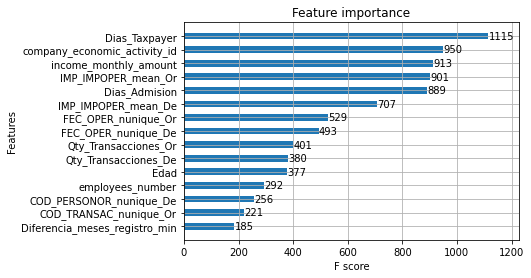

In [ ]:
plt.figure(figsize=(40,20))
xgb.plot_importance(modelo_xgb,height=0.5,max_num_features=20,importance_type='weight')


In [ ]:
modelo_xgb.get_fscore().items()
variables_importantes = pd.DataFrame(modelo_xgb.get_fscore().items(), columns=['Variable','Importancia']).sort_values('Importancia', ascending=False)
variables_importantes.head()

,Variable,Importancia
5,Dias_Taxpayer,1093
8,company_economic_activity_id,923
0,IMP_IMPOPER_mean_Or,868
1,income_monthly_amount,821
2,Dias_Admision,814


In [ ]:
#variables_importantes_xgb = list(variables_importantes.head(15).Variable)

In [ ]:
prediccion_test= modelo_xgb.predict(data_test,ntree_limit=modelo_xgb.best_iteration)
prediccion_train= modelo_xgb.predict(data_train,ntree_limit=modelo_xgb.best_iteration)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


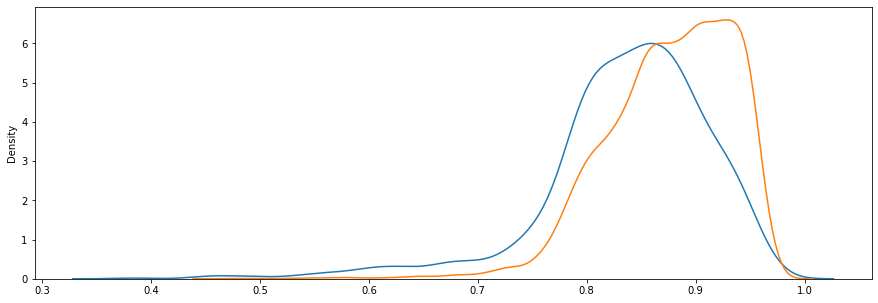

In [ ]:
graficar_probabilidades(prediccion_test, y_test)

In [ ]:
print(classification_report(y_test, [1 if x>0.88 else 0 for x in prediccion_test]))

              precision    recall  f1-score   support

         0.0       0.18      0.70      0.29      1268
         1.0       0.92      0.52      0.67      8511

    accuracy                           0.54      9779
   macro avg       0.55      0.61      0.48      9779
weighted avg       0.83      0.54      0.62      9779



Modelo LightGBM

In [ ]:

import lightgbm as lgb

train_data_lgb = lgb.Dataset(X_train[variables_importantes_xgb], label=y_train)
test_data_lgb = lgb.Dataset(X_test[variables_importantes_xgb], label=y_test)

In [ ]:
variables_importantes_xgb

['Dias_Taxpayer',
 'company_economic_activity_id',
 'IMP_IMPOPER_mean_Or',
 'income_monthly_amount',
 'Dias_Admision',
 'IMP_IMPOPER_mean_De',
 'FEC_OPER_nunique_Or',
 'FEC_OPER_nunique_De',
 'Qty_Transacciones_Or',
 'Qty_Transacciones_De',
 'Edad',
 'employees_number',
 'COD_PERSONOR_nunique_De',
 'COD_TRANSAC_nunique_Or',
 'Diferencia_meses_registro_min']

In [ ]:
 parameters = {
    'application': 'binary', # binary
    'objective': 'binary', # binary
    'metric': 'auc',
    'boosting': 'gbdt',
    'num_leaves': 10,#31,
    'max_depth': 4,
    #'max_bin': 1500,
    'min_data_in_leaf': 22,
    'min_split_gain': 0.03,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 20,
    'learning_rate': 0.03,
    'verbose': 0
}


In [ ]:
model = lgb.train(parameters,
                       train_data_lgb,
                       valid_sets=test_data_lgb,
                       num_boost_round=16000,
                       early_stopping_rounds=100, verbose_eval=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.654235
[200]	valid_0's auc: 0.657357
Early stopping, best iteration is:
[191]	valid_0's auc: 0.657609


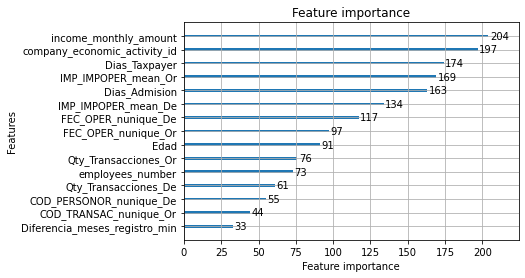

In [ ]:
ax = lgb.plot_importance(model, max_num_features=20)
plt.show()


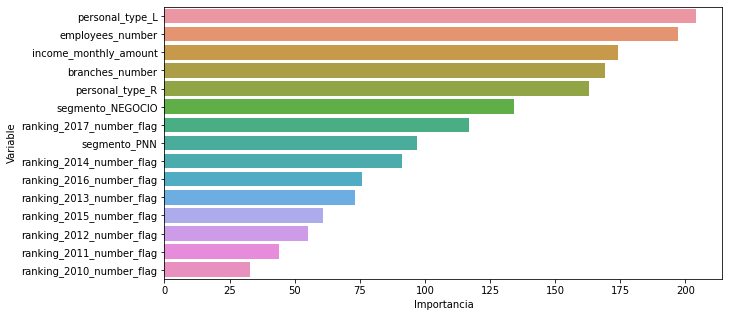

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),X_train.columns)), columns=['Importancia','Variable'])
feature_imp.sort_values(by='Importancia', ascending=False, inplace=True)  
plt.figure(figsize=(10,5))
sns.barplot(x="Importancia", y="Variable", data=feature_imp.head(20))

In [ ]:
variables_importantes_lgb = feature_imp.head(15)

In [ ]:
prediccion_lgb_test = model.predict(X_test[variables_importantes_xgb], num_iteration=model.best_iteration)
prediccion_lgb_train = model.predict(X_train[variables_importantes_xgb], num_iteration=model.best_iteration)

In [ ]:
model.save_model(path+'Modelo_clientes_clasificacion_v1.model')

In [ ]:
model.best_iteration

191

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


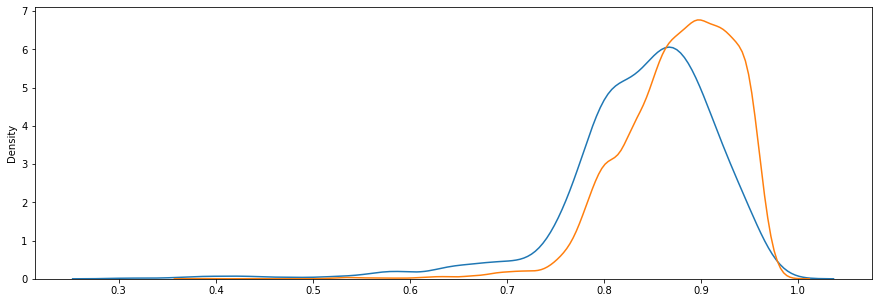

In [ ]:
graficar_probabilidades(prediccion_lgb_test, y_test)

In [ ]:
print(classification_report(y_test, [1 if x>0.88 else 0 for x in prediccion_lgb_test]))

              precision    recall  f1-score   support

         0.0       0.18      0.69      0.28      1268
         1.0       0.92      0.53      0.67      8511

    accuracy                           0.55      9779
   macro avg       0.55      0.61      0.48      9779
weighted avg       0.82      0.55      0.62      9779



In [ ]:
variables_importantes_xgb

['Dias_Taxpayer',
 'company_economic_activity_id',
 'IMP_IMPOPER_mean_Or',
 'income_monthly_amount',
 'Dias_Admision',
 'IMP_IMPOPER_mean_De',
 'FEC_OPER_nunique_Or',
 'FEC_OPER_nunique_De',
 'Qty_Transacciones_Or',
 'Qty_Transacciones_De',
 'Edad',
 'employees_number',
 'COD_PERSONOR_nunique_De',
 'COD_TRANSAC_nunique_Or',
 'Diferencia_meses_registro_min']

#### Modelo no cliente

In [ ]:
informacion_no_clientes = ['Dias_Taxpayer','company_economic_activity_id','income_monthly_amount','Dias_Admision','Edad','employees_number']

In [ ]:

data_train = xgb.DMatrix(X_train[informacion_no_clientes], y_train)
data_test = xgb.DMatrix(X_test[informacion_no_clientes], y_test)

evallist = [(data_test, 'validation'), (data_train, 'train')]

In [ ]:
modelo_xgb_no_cliente = xgb.train(param, data_train, num_round, evallist,verbose_eval=20,early_stopping_rounds=100)

[0]	validation-auc:0.592392	train-auc:0.601903
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 100 rounds.
[20]	validation-auc:0.604833	train-auc:0.621517
[40]	validation-auc:0.604494	train-auc:0.624752
[60]	validation-auc:0.604791	train-auc:0.625451
[80]	validation-auc:0.604947	train-auc:0.627522
[100]	validation-auc:0.606619	train-auc:0.629502
[120]	validation-auc:0.60673	train-auc:0.630802
[140]	validation-auc:0.607606	train-auc:0.632284
[160]	validation-auc:0.608836	train-auc:0.633769
[180]	validation-auc:0.609727	train-auc:0.635166
[200]	validation-auc:0.610541	train-auc:0.636273
[220]	validation-auc:0.611738	train-auc:0.638134
[240]	validation-auc:0.61288	train-auc:0.640619
[260]	validation-auc:0.613838	train-auc:0.642519
[280]	validation-auc:0.614067	train-auc:0.644135
[300]	validation-auc:0.614651	train-auc:0.645475
[320]	validation-auc:0.615327	train-auc:0.647087
[340]	validation-auc:0.615317	t

In [ ]:
prediccion_test_no_cliente= modelo_xgb_no_cliente.predict(data_test,ntree_limit=modelo_xgb_no_cliente.best_iteration)
prediccion_train_no_cliente= modelo_xgb_no_cliente.predict(data_train,ntree_limit=modelo_xgb_no_cliente.best_iteration)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


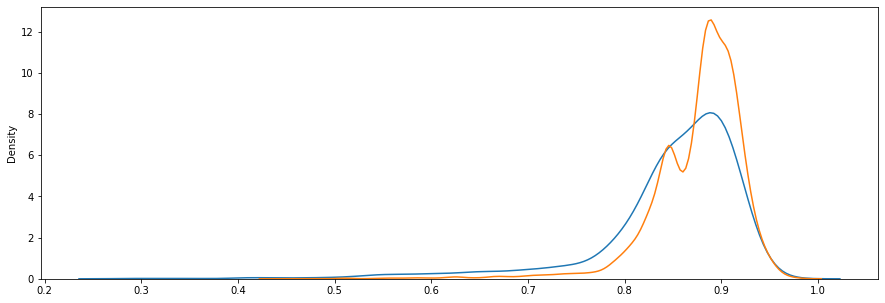

In [ ]:
graficar_probabilidades(prediccion_test_no_cliente, y_test)

In [ ]:
print(classification_report(y_test, [1 if x>0.85 else 0 for x in prediccion_test_no_cliente]))

              precision    recall  f1-score   support

         0.0       0.20      0.41      0.27      1268
         1.0       0.90      0.75      0.82      8511

    accuracy                           0.71      9779
   macro avg       0.55      0.58      0.54      9779
weighted avg       0.81      0.71      0.75      9779



In [ ]:
train_data_lgb_no_clientes = lgb.Dataset(X_train[informacion_no_clientes], label=y_train)
test_data_lgb_no_clientes = lgb.Dataset(X_test[informacion_no_clientes], label=y_test)

In [ ]:
model_no_clientes = lgb.train(parameters,
                       train_data_lgb_no_clientes,
                       valid_sets=test_data_lgb_no_clientes,
                       num_boost_round=16000,
                       early_stopping_rounds=100, verbose_eval=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.615508
[200]	valid_0's auc: 0.613974
Early stopping, best iteration is:
[109]	valid_0's auc: 0.616137


In [ ]:
prediccion_lgb_test = model_no_clientes.predict(X_test[informacion_no_clientes], num_iteration=model_no_clientes.best_iteration)
prediccion_lgb_train = model_no_clientes.predict(X_train[informacion_no_clientes], num_iteration=model_no_clientes.best_iteration)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


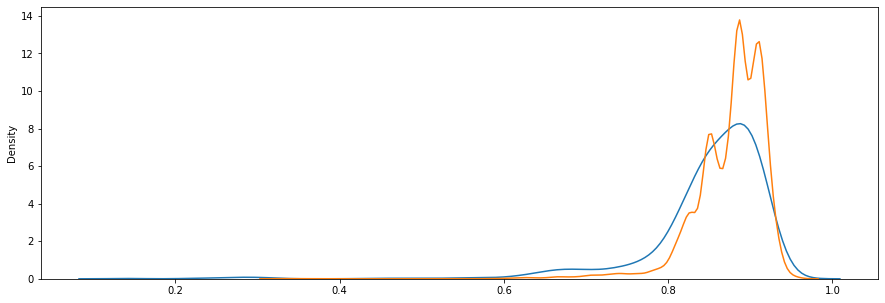

In [ ]:
graficar_probabilidades(prediccion_lgb_test, y_test)

In [ ]:
print(classification_report(y_test, [1 if x>0.85 else 0 for x in prediccion_lgb_test]))

              precision    recall  f1-score   support

         0.0       0.21      0.40      0.27      1268
         1.0       0.90      0.77      0.83      8511

    accuracy                           0.73      9779
   macro avg       0.55      0.58      0.55      9779
weighted avg       0.81      0.73      0.76      9779



In [ ]:
model_no_clientes.save_model(path+'Modelo_No_clientes_clasificacion_v1.model')

In [ ]:
model_no_clientes.best_iteration

109

Modelo regresión

In [ ]:
X = data_final_le[(data_final_le['Flag_Credito']==1)&(data_final_le['balance_amount']>=100)&(data_final_le['balance_amount']<200000)].drop(['personal_id','customer_id','sbs_customer_id','taxpayer_id','Flag_Credito','Tiene_target','balance_amount'],axis=1).copy()
y_reg = data_final_le[(data_final_le['Flag_Credito']==1)&(data_final_le['balance_amount']>=100)&(data_final_le['balance_amount']<200000)]['balance_amount'].copy()

In [ ]:
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.3, random_state=42)

In [ ]:
X_train = pd.merge(X_train, X_train_aux[['company_economic_activity_id','company_target_mean']],how='left',on='company_economic_activity_id')
X_test = pd.merge(X_test, X_train_aux[['company_economic_activity_id','company_target_mean']],how='left',on='company_economic_activity_id')

In [ ]:
X_train.drop('company_economic_activity_id',axis=1,inplace=True)
X_test.drop('company_economic_activity_id',axis=1,inplace=True)

X_train.rename(columns={'company_target_mean':'company_economic_activity_id'},inplace=True)
X_test.rename(columns={'company_target_mean':'company_economic_activity_id'},inplace=True)

In [ ]:
import lightgbm as lgb

train_data_lgb = lgb.Dataset(X_train[variables_importantes_lgb_reg], label=y_train_reg)
test_data_lgb = lgb.Dataset(X_test[variables_importantes_lgb_reg], label=y_test_reg)

In [ ]:
parameters = {
    'application': 'regression', # binary
    'objective': 'regression', # binary
    'metric': 'rmse',
    'boosting': 'gbdt',
    'num_leaves': 10,#31,
    'max_depth': 4,
    #'max_bin': 1500,
    'min_data_in_leaf': 22,
    'min_split_gain': 0.03,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 20,
    'learning_rate': 0.003,
    'verbose': 0
}

In [ ]:
modelo_reg = lgb.train(parameters,
                       train_data_lgb,
                       valid_sets=test_data_lgb,
                       num_boost_round=16000,
                       early_stopping_rounds=100, verbose_eval=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 55289.9
[200]	valid_0's rmse: 54890.1
[300]	valid_0's rmse: 54636.8
[400]	valid_0's rmse: 54459.3
[500]	valid_0's rmse: 54329.9
[600]	valid_0's rmse: 54245.1
[700]	valid_0's rmse: 54164.9
[800]	valid_0's rmse: 54104.8
[900]	valid_0's rmse: 54049.5
[1000]	valid_0's rmse: 54007.7
[1100]	valid_0's rmse: 53976.7
[1200]	valid_0's rmse: 53963.2
[1300]	valid_0's rmse: 53933.5
[1400]	valid_0's rmse: 53908.2
[1500]	valid_0's rmse: 53891.3
[1600]	valid_0's rmse: 53884.3
[1700]	valid_0's rmse: 53864.7
[1800]	valid_0's rmse: 53861.3
Early stopping, best iteration is:
[1779]	valid_0's rmse: 53859.1


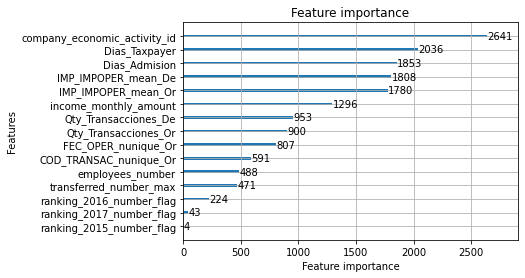

In [ ]:
ax = lgb.plot_importance(modelo_reg, max_num_features=20)
plt.show()

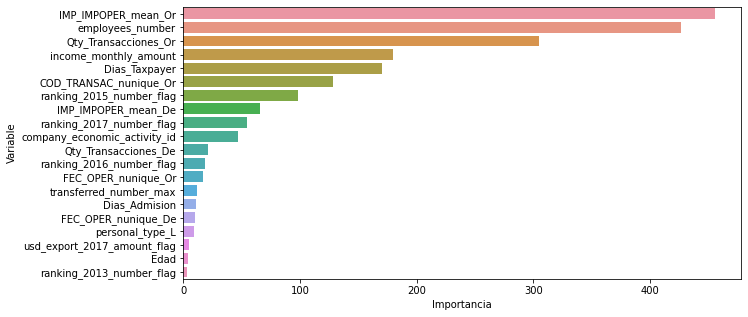

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(modelo_reg.feature_importance(),X_train[columnas_modelo_nocor].columns)), columns=['Importancia','Variable'])
feature_imp.sort_values(by='Importancia', ascending=False, inplace=True)  
plt.figure(figsize=(10,5))
sns.barplot(x="Importancia", y="Variable", data=feature_imp.head(20))

In [ ]:
#variables_importantes_lgb_reg = list(feature_imp.head(15).Variable)
#variables_importantes_lgb_reg

['IMP_IMPOPER_mean_Or',
 'employees_number',
 'Qty_Transacciones_Or',
 'income_monthly_amount',
 'Dias_Taxpayer',
 'COD_TRANSAC_nunique_Or',
 'ranking_2015_number_flag',
 'IMP_IMPOPER_mean_De',
 'ranking_2017_number_flag',
 'company_economic_activity_id',
 'Qty_Transacciones_De',
 'ranking_2016_number_flag',
 'FEC_OPER_nunique_Or',
 'transferred_number_max',
 'Dias_Admision']

In [ ]:
prediccion_lgb_test = modelo_reg.predict(X_test[variables_importantes_lgb_reg], num_iteration=modelo_reg.best_iteration)
prediccion_lgb_train = modelo_reg.predict(X_train[variables_importantes_lgb_reg], num_iteration=modelo_reg.best_iteration)

In [ ]:
min(prediccion_lgb_test),np.mean(prediccion_lgb_test),max(prediccion_lgb_test)

(28773.863273497245, 67552.56841928078, 111257.27119071226)

In [ ]:
modelo_reg.save_model(path+'Modelo_clientes_regression_v1.model')

In [ ]:
modelo_reg.best_iteration

1779

Modelo regresión no cliente

In [ ]:
import lightgbm as lgb

train_data_lgb = lgb.Dataset(X_train[informacion_no_clientes], label=y_train_reg)
test_data_lgb = lgb.Dataset(X_test[informacion_no_clientes], label=y_test_reg)

In [ ]:
modelo_reg_no_clientes = lgb.train(parameters,
                       train_data_lgb,
                       valid_sets=test_data_lgb,
                       num_boost_round=16000,
                       early_stopping_rounds=100, verbose_eval=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 55317.4
[200]	valid_0's rmse: 54954.4
[300]	valid_0's rmse: 54749.6
[400]	valid_0's rmse: 54600.7
[500]	valid_0's rmse: 54492.8
[600]	valid_0's rmse: 54424.1
[700]	valid_0's rmse: 54368.9
[800]	valid_0's rmse: 54328.3
[900]	valid_0's rmse: 54303.2
[1000]	valid_0's rmse: 54285.3
[1100]	valid_0's rmse: 54268.4
[1200]	valid_0's rmse: 54262.7
[1300]	valid_0's rmse: 54254
[1400]	valid_0's rmse: 54252
[1500]	valid_0's rmse: 54251
[1600]	valid_0's rmse: 54246.6
[1700]	valid_0's rmse: 54242.6
[1800]	valid_0's rmse: 54239
[1900]	valid_0's rmse: 54239.2
Early stopping, best iteration is:
[1829]	valid_0's rmse: 54236.5


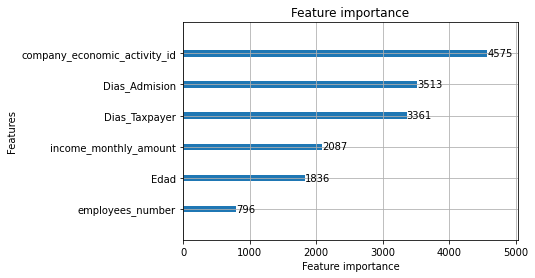

In [ ]:
ax = lgb.plot_importance(modelo_reg_no_clientes, max_num_features=20)
plt.show()

In [ ]:
prediccion_lgb_test_no_cliente = modelo_reg_no_clientes.predict(X_test[informacion_no_clientes], num_iteration=modelo_reg_no_clientes.best_iteration)
prediccion_lgb_train_no_cliente = modelo_reg_no_clientes.predict(X_train[informacion_no_clientes], num_iteration=modelo_reg_no_clientes.best_iteration)

In [ ]:
min(prediccion_lgb_test_no_cliente),np.mean(prediccion_lgb_test_no_cliente),max(prediccion_lgb_test_no_cliente)

(29340.118286371282, 67360.13960084856, 97194.12442308008)

In [ ]:
modelo_reg_no_clientes.save_model(path+'Modelo_No_clientes_regression_v1.model')

In [ ]:
modelo_reg_no_clientes.best_iteration

1829

# RÉPLICAS

In [ ]:
ruc_cliente = '37374480882'

In [ ]:
#Variables a definir

se_entrega_credito = 0
monto_credito = 0

Clientes BBVA

In [ ]:
# Cargar el dataset (Matriz_datos) / Matriz_CIIU

In [ ]:
Matriz_datos = data_final_le.copy()
Matriz_CIIU = X_train_aux.copy()

In [ ]:
Matriz_datos = Matriz_datos[Matriz_datos['taxpayer_id']==int(ruc_cliente)].head(1).copy()

In [ ]:
Matriz_datos.head()

,personal_id,customer_id,sbs_customer_id,taxpayer_id,income_monthly_amount,employees_number,branches_number,personal_type_L,personal_type_R,segmento_NEGOCIO,segmento_PNN,ranking_2017_number_flag,ranking_2016_number_flag,ranking_2015_number_flag,ranking_2014_number_flag,ranking_2013_number_flag,ranking_2012_number_flag,ranking_2011_number_flag,ranking_2010_number_flag,min_usd_billing_2017_amount_flag,min_usd_billing_2016_amount_flag,min_usd_billing_2015_amount_flag,min_usd_billing_2014_amount_flag,min_usd_billing_2013_amount_flag,max_usd_billing_2017_amount_flag,max_usd_billing_2016_amount_flag,max_usd_billing_2015_amount_flag,max_usd_billing_2014_amount_flag,max_usd_billing_2013_amount_flag,min_pen_billing_2017_amount_flag,min_pen_billing_2016_amount_flag,min_pen_billing_2015_amount_flag,min_pen_billing_2014_amount_flag,min_pen_billing_2013_amount_flag,max_pen_billing_2017_amount_flag,max_pen_billing_2016_amount_flag,max_pen_billing_2015_amount_flag,max_pen_billing_2014_amount_flag,max_pen_billing_2013_amount_flag,income_2017_amount_flag,income_2016_amount_flag,income_2015_amount_flag,income_2014_amount_flag,income_2013_amount_flag,income_2012_amount_flag,income_2011_amount_flag,income_2010_amount_flag,income_2009_amount_flag,income_2008_amount_flag,income_2007_amount_flag,income_2006_amount_flag,income_2005_amount_flag,income_2004_amount_flag,income_2003_amount_flag,income_2002_amount_flag,income_2001_amount_flag,income_2000_amount_flag,net_profit_2017_amount_flag,net_profit_2016_amount_flag,net_profit_2015_amount_flag,net_profit_2014_amount_flag,net_profit_2013_amount_flag,net_profit_2012_amount_flag,net_profit_2011_amount_flag,net_profit_2010_amount_flag,net_profit_2009_amount_flag,net_profit_2008_amount_flag,net_profit_2007_amount_flag,net_profit_2006_amount_flag,net_profit_2005_amount_flag,net_profit_2004_amount_flag,net_profit_2003_amount_flag,net_profit_2002_amount_flag,net_profit_2001_amount_flag,net_profit_2000_amount_flag,assets_2016_amount_flag,assets_2015_amount_flag,assets_2014_amount_flag,assets_2013_amount_flag,assets_2012_amount_flag,assets_2011_amount_flag,assets_2010_amount_flag,assets_2009_amount_flag,assets_2008_amount_flag,assets_2007_amount_flag,assets_2006_amount_flag,assets_2005_amount_flag,assets_2004_amount_flag,assets_2003_amount_flag,assets_2002_amount_flag,assets_2001_amount_flag,assets_2000_amount_flag,equity_2016_amount_flag,equity_2015_amount_flag,equity_2014_amount_flag,equity_2013_amount_flag,equity_2012_amount_flag,equity_2011_amount_flag,equity_2010_amount_flag,equity_2009_amount_flag,equity_2008_amount_flag,equity_2007_amount_flag,equity_2006_amount_flag,equity_2005_amount_flag,equity_2004_amount_flag,equity_2003_amount_flag,equity_2002_amount_flag,equity_2001_amount_flag,equity_2000_amount_flag,liabilities_2016_amount_flag,liabilities_2015_amount_flag,liabilities_2014_amount_flag,liabilities_2013_amount_flag,liabilities_2012_amount_flag,liabilities_2011_amount_flag,liabilities_2010_amount_flag,liabilities_2009_amount_flag,liabilities_2008_amount_flag,liabilities_2007_amount_flag,liabilities_2006_amount_flag,liabilities_2005_amount_flag,liabilities_2004_amount_flag,liabilities_2003_amount_flag,liabilities_2002_amount_flag,liabilities_2001_amount_flag,usd_export_2017_amount_flag,usd_export_2016_amount_flag,usd_export_2015_amount_flag,usd_export_2014_amount_flag,usd_export_2013_amount_flag,usd_export_2012_amount_flag,usd_export_2011_amount_flag,usd_export_2010_amount_flag,usd_export_2009_amount_flag,usd_export_2008_amount_flag,usd_export_2007_amount_flag,usd_export_2006_amount_flag,usd_export_2005_amount_flag,usd_export_2004_amount_flag,usd_export_2003_amount_flag,usd_export_2002_amount_flag,usd_export_2001_amount_flag,usd_export_2000_amount_flag,usd_export_1999_amount_flag,usd_export_1998_amount_flag,usd_export_1997_amount_flag,usd_export_1996_amount_flag,usd_export_1995_amount_flag,usd_export_1994_amount_flag,usd_export_1993_amount_flag,usd_import_2017_amount_flag,usd_import_2016_amount_fla

In [ ]:
Matriz_datos = pd.merge(Matriz_datos, Matriz_CIIU[['company_economic_activity_id','company_target_mean']],how='left',on='company_economic_activity_id')

In [ ]:
Matriz_datos.drop('company_economic_activity_id',axis=1,inplace=True)
Matriz_datos.rename(columns={'company_target_mean':'company_economic_activity_id'},inplace=True)

In [ ]:
if Matriz_datos['Tiene_target'][0]==1:
  se_entrega_credito = Matriz_datos['Flag_Credito'][0]
  monto_credito = Matriz_datos['balance_amount'][0]
else:

  import lightgbm as lgb
  Variables_clasificacion= ['Dias_Taxpayer','company_economic_activity_id','IMP_IMPOPER_mean_Or','income_monthly_amount','Dias_Admision','IMP_IMPOPER_mean_De','FEC_OPER_nunique_Or','FEC_OPER_nunique_De','Qty_Transacciones_Or','Qty_Transacciones_De','Edad','employees_number','COD_PERSONOR_nunique_De','COD_TRANSAC_nunique_Or','Diferencia_meses_registro_min']
  Variables_regression = ['IMP_IMPOPER_mean_Or', 'employees_number', 'Qty_Transacciones_Or', 'income_monthly_amount', 'Dias_Taxpayer', 'COD_TRANSAC_nunique_Or', 'ranking_2015_number_flag', 'IMP_IMPOPER_mean_De', 'ranking_2017_number_flag', 'company_economic_activity_id', 'Qty_Transacciones_De', 'ranking_2016_number_flag', 'FEC_OPER_nunique_Or', 'transferred_number_max', 'Dias_Admision']

  modelo_entrenado_cliente_cla = lgb.Booster(model_file=path+'Modelo_clientes_clasificacion_v1.model')
  modelo_entrenado_cliente_reg = lgb.Booster(model_file=path+'Modelo_clientes_regression_v1.model')

  prediccion_cliente_cla = modelo_entrenado_cliente_cla.predict(Matriz_datos[Variables_clasificacion], num_iteration=modelo_entrenado_cliente_cla.best_iteration)
  prediccion_cliente_reg = modelo_entrenado_cliente_reg.predict(Matriz_datos[Variables_regression], num_iteration=modelo_entrenado_cliente_reg.best_iteration)

  se_entrega_credito = [1 if x>0.88 else 0 for x in prediccion_cliente_cla][0]
  monto_credito = round(prediccion_cliente_reg[0],0)

In [ ]:
print(se_entrega_credito,monto_credito)

0 48645.0


Clientes no BBVA

In [ ]:
informacion_no_clientes = ['Dias_Taxpayer','company_economic_activity_id','income_monthly_amount','Dias_Admision','Edad','employees_number']

Datos del formulario

In [ ]:
ruc = '20549500553'
income_monthly_amount = 5000 # Ingresos mensuales
Fecha_nacimiento = '20/10/1994'
employees_number = 20 # número de empleados

Data SUNAT

In [ ]:
datos_SUNAT = pd.read_csv(path+'sample_data_sunat.csv',sep=',')

In [ ]:
def obtener_RUC(x):
  return str(x).strip().split(' ')[0]

def obtener_fecha_inscripcion(x):
  return str(x).strip().split(',')[0]

def obtener_fecha_Inicio_Actividades(x):
  return str(x).strip().split(',')[2]

In [ ]:
datos_SUNAT['RUC'] = datos_SUNAT['Número de RUC'].apply(lambda x: obtener_RUC(x))
datos_SUNAT['Fecha_de_Inscripcion'] = datos_SUNAT['Fecha de Inscripción'].apply(lambda x: obtener_fecha_inscripcion(x))
datos_SUNAT['Fecha_de_Inicio_de_Actividades'] = datos_SUNAT['Fecha de Inscripción'].apply(lambda x: obtener_fecha_Inicio_Actividades(x))

In [ ]:
datos_SUNAT['Estado del Contribuyente'] = datos_SUNAT['Estado del Contribuyente'].apply(lambda x: x.split(',')[0])
datos_SUNAT['Sistema_Emision_Comprobante'] = datos_SUNAT['Sistema de Emisión de Comprobante'].apply(lambda x: str(x).strip().split(',')[0])
datos_SUNAT['Actividad de Comercio Exterior'] = datos_SUNAT['Sistema de Emisión de Comprobante'].apply(lambda x: str(x).strip().split(',')[2])
datos_SUNAT['Actividad Economica'] = datos_SUNAT['Actividad(es) Económica(s)'].apply(lambda x: str(x).strip().split(' ')[0])

In [ ]:
def obtener_departamento(x):
  departamento = str(x).split('-')[0].strip()
  return departamento.split(' ')[-1]

def obtener_provincia(x):
  return str(x).split('-')[1].strip()

def obtener_distrito(x):
  return str(x).split('-')[2].strip()

In [ ]:
datos_SUNAT['Departamento'] = datos_SUNAT['Dirección del Domicilio Fiscal'].apply(lambda x: obtener_departamento(x))
datos_SUNAT['Provincia'] = datos_SUNAT['Dirección del Domicilio Fiscal'].apply(lambda x: obtener_provincia(x))
datos_SUNAT['Distrito'] = datos_SUNAT['Dirección del Domicilio Fiscal'].apply(lambda x: obtener_distrito(x))

In [ ]:
datos_SUNAT.head()

,Número de RUC,Tipo Contribuyente,Nombre Comercial,Fecha de Inscripción,Estado del Contribuyente,Condición del Contribuyente,Dirección del Domicilio Fiscal,Sistema de Emisión de Comprobante,Sistema de Contabilidad,Actividad(es) Económica(s),Comprobantes de Pago c/aut. de impresión (F. 806 u 816),Sistema de Emision Electronica,Emisor electrónico desde,Comprobantes Electrónicos,Afiliado al PLE desde,Padrones,RUC,Fecha_de_Inscripcion,Fecha_de_Inicio_de_Actividades,Sistema_Emision_Comprobante,Actividad de Comercio Exterior,Actividad Economica,Departamento,Provincia,Distrito
0,20538856674 - ARTROSCOPICTRAUMA S.A.C.,SOCIEDAD ANONIMA CERRADA,-,"26/12/2012,Fecha de Inicio de Actividades:,26/...",ACTIVO,HABIDO,AV. GRAL.GARZON NRO. 2320 URB. FUNDO OYAGUE LI...,"MANUAL,Actividad de Comercio Exterior:,SIN ACT...",MANUAL,85193 - OTRAS ACTIV.RELAC. CON SALUD HUMANA,FACTURA,FACTURA PORTAL DESDE 15/0...,15/03/2016,FACTURA (desde 15/03/2016),-,Incorporado al Régimen de Buenos Contribuyente...,20538856674,26/12/2012,26/12/2012,MANUAL,SIN ACTIVIDAD,85193,LIMA,LIMA,JESUS MARIA
1,20549500553 - ASERCO EB EMPRESA INDIVIDUAL DE ...,EMPRESA INDIVIDUAL DE RESP. LTDA,-,"06/09/2012,Fecha de Inicio de Actividades:,17/...",ACTIVO,HABIDO,AV. PASEO DE LA REPUBLICA NRO. 291 INT. 903 (P...,"MANUAL,Actividad de Comercio Exterior:,SIN ACT...",MANUAL,74145 - ACTIV.DE ASESORAMIENTO EMPRESARIAL,FACTURA\n \n \n ...,-,-,-,-,Incorporado al Régimen de Buenos Contribuyente...,20549500553,06/09/2012,17/09/2012,MANUAL,SIN ACTIVIDAD,74145,LIMA,LIMA,LIMA
2,20551597939 - ASOCIACION COMUNIDAD CRISTIANA E...,ASOCIACION,-,"14/02/2013,Fecha de Inicio de Actividades:,17/...",ACTIVO,HABIDO,AV. CANTO BELLO MZA. O LOTE. 32 A.H. SAN FERNA...,"MANUAL,Actividad de Comercio Exterior:,SIN ACT...",MANUAL,9499 - ACTIVIDADES DE OTRAS ASOCIACIONES N.C.P.,NINGUNO,-,-,-,-,Incorporado al Régimen de Buenos Contribuyente...,20551597939,14/02/2013,17/10/2013,MANUAL,SIN ACTIVIDAD,9499,LIMA,LIMA,SAN JUAN DE LURIGANCHO
3,20601155185 - CORPORACION CARMINA SAC,SOCIEDAD ANONIMA CERRADA,-,"15/04/2016,Fecha de Inicio de Actividades:,01/...",ACTIVO,HABIDO,CAL.LOS MOJAVES NRO. 278 SALAMANCA (ALT CDRA 9...,"MANUAL/COMPUTARIZADO,Actividad de Comercio Ext...",MANUAL/COMPUTARIZADO,4649 - VENTA AL POR MAYOR DE OTROS ENSERES DOM...,FACTURA\n \n \n ...,FACTURA PORTAL DESDE 17/0...,17/04/2019,"FACTURA (desde 17/04/2019),BOLETA (desde 01/10...",-,Incorporado al Régimen de Buenos Contribuyente...,20601155185,15/04/2016,01/05/2016,MANUAL/COMPUTARIZADO,IMPORTADOR/EXPORTADOR,4649,LIMA,LIMA,ATE
4,20555629541 - CORPORACION INDUSTRIAL ALPA`C S....,SOCIEDAD ANONIMA CERRADA,CORPORACION INDUSTRIAL ALPA´C,"03/12/2013,Fecha de Inicio de Actividades:,06/...",ACTIVO,HABIDO,CAL.AMERICA NRO. 544 URB. SAN PABLO (JR AMERIC...,"MANUAL,Actividad de Comercio Exterior:,IMPORTA...",MANUAL/COMPUTARIZADO,4641 - VENTA AL POR MAYOR DE PRODUCTOS TEXTILE...,FACTURA\n \n \n ...,FACTURA PORTAL DESDE 11/0...,11/03/2019,"FACTURA (desde 11/03/2019),BOLETA (desde 20/03...",01/01/2015,Incorporado al Régimen de Buenos Contribuyente...,20555629541,03/12/2013,06/12/2013,MANUAL,IMPORTADOR/EXPORTADOR,4641,LIMA,LIMA,LA VICTORIA


In [ ]:
datos_SUNAT_cliente = datos_SUNAT[datos_SUNAT['RUC']==ruc].head(1).copy()

In [ ]:
datos_SUNAT_cliente.head()

,Número de RUC,Tipo Contribuyente,Nombre Comercial,Fecha de Inscripción,Estado del Contribuyente,Condición del Contribuyente,Dirección del Domicilio Fiscal,Sistema de Emisión de Comprobante,Sistema de Contabilidad,Actividad(es) Económica(s),Comprobantes de Pago c/aut. de impresión (F. 806 u 816),Sistema de Emision Electronica,Emisor electrónico desde,Comprobantes Electrónicos,Afiliado al PLE desde,Padrones,RUC,Fecha_de_Inscripcion,Fecha_de_Inicio_de_Actividades,Sistema_Emision_Comprobante,Actividad de Comercio Exterior,Actividad Economica,Departamento,Provincia,Distrito
1,20549500553 - ASERCO EB EMPRESA INDIVIDUAL DE ...,EMPRESA INDIVIDUAL DE RESP. LTDA,-,"06/09/2012,Fecha de Inicio de Actividades:,17/...",ACTIVO,HABIDO,AV. PASEO DE LA REPUBLICA NRO. 291 INT. 903 (P...,"MANUAL,Actividad de Comercio Exterior:,SIN ACT...",MANUAL,74145 - ACTIV.DE ASESORAMIENTO EMPRESARIAL,FACTURA\n \n \n ...,-,-,-,-,Incorporado al Régimen de Buenos Contribuyente...,20549500553,06/09/2012,17/09/2012,MANUAL,SIN ACTIVIDAD,74145,LIMA,LIMA,LIMA


In [ ]:
datos_SUNAT_cliente['birth_date'] = Fecha_nacimiento
datos_SUNAT_cliente['income_monthly_amount'] = income_monthly_amount
datos_SUNAT_cliente['employees_number'] = employees_number

In [ ]:
datos_SUNAT_cliente['birth_date'] = pd.to_datetime(datos_SUNAT_cliente.birth_date, format='%d/%m/%Y')
datos_SUNAT_cliente['Fecha_de_Inscripcion'] = pd.to_datetime(datos_SUNAT_cliente.Fecha_de_Inscripcion, format='%d/%m/%Y')
datos_SUNAT_cliente['Fecha_de_Inicio_de_Actividades'] = pd.to_datetime(datos_SUNAT_cliente.Fecha_de_Inicio_de_Actividades, format='%d/%m/%Y')

In [ ]:

datos_SUNAT_cliente['Dias_Admision'] = (datetime.datetime.utcnow() -datos_SUNAT_cliente['Fecha_de_Inscripcion']).astype('timedelta64[D]')
datos_SUNAT_cliente['Dias_Taxpayer'] = (datetime.datetime.utcnow() -datos_SUNAT_cliente['Fecha_de_Inicio_de_Actividades']).astype('timedelta64[D]')
datos_SUNAT_cliente['Edad'] = datos_SUNAT_cliente['birth_date'].apply(lambda x: 2020-int(str(x)[0:4]))

In [ ]:
datos_SUNAT_cliente['company_economic_activity_id'] = datos_SUNAT_cliente['Actividad Economica']

In [ ]:
datos_SUNAT_cliente = pd.merge(datos_SUNAT_cliente, Matriz_CIIU[['company_economic_activity_id','company_target_mean']],how='left',on='company_economic_activity_id')
datos_SUNAT_cliente.drop('company_economic_activity_id',axis=1,inplace=True)
datos_SUNAT_cliente.rename(columns={'company_target_mean':'company_economic_activity_id'},inplace=True)
datos_SUNAT_cliente.head()


,Número de RUC,Tipo Contribuyente,Nombre Comercial,Fecha de Inscripción,Estado del Contribuyente,Condición del Contribuyente,Dirección del Domicilio Fiscal,Sistema de Emisión de Comprobante,Sistema de Contabilidad,Actividad(es) Económica(s),Comprobantes de Pago c/aut. de impresión (F. 806 u 816),Sistema de Emision Electronica,Emisor electrónico desde,Comprobantes Electrónicos,Afiliado al PLE desde,Padrones,RUC,Fecha_de_Inscripcion,Fecha_de_Inicio_de_Actividades,Sistema_Emision_Comprobante,Actividad de Comercio Exterior,Actividad Economica,Departamento,Provincia,Distrito,birth_date,income_monthly_amount,employees_number,Dias_Admision,Dias_Taxpayer,Edad,company_economic_activity_id
0,20549500553 - ASERCO EB EMPRESA INDIVIDUAL DE ...,EMPRESA INDIVIDUAL DE RESP. LTDA,-,"06/09/2012,Fecha de Inicio de Actividades:,17/...",ACTIVO,HABIDO,AV. PASEO DE LA REPUBLICA NRO. 291 INT. 903 (P...,"MANUAL,Actividad de Comercio Exterior:,SIN ACT...",MANUAL,74145 - ACTIV.DE ASESORAMIENTO EMPRESARIAL,FACTURA\n \n \n ...,-,-,-,-,Incorporado al Régimen de Buenos Contribuyente...,20549500553,2012-09-06,2012-09-17,MANUAL,SIN ACTIVIDAD,74145,LIMA,LIMA,LIMA,1994-10-20,5000,20,2964.0,2953.0,26,0.913208


In [ ]:
if datos_SUNAT_cliente['Estado del Contribuyente'][0]=='ACTIVO':
  import lightgbm as lgb

  modelo_entrenado_No_cliente_cla = lgb.Booster(model_file=path+'Modelo_No_clientes_clasificacion_v1.model')
  modelo_entrenado_No_cliente_reg = lgb.Booster(model_file=path+'Modelo_No_clientes_regression_v1.model')

  prediccion_No_cliente_cla = modelo_entrenado_No_cliente_cla.predict(datos_SUNAT_cliente[informacion_no_clientes], num_iteration=modelo_entrenado_No_cliente_cla.best_iteration)
  prediccion_No_cliente_reg = modelo_entrenado_No_cliente_reg.predict(datos_SUNAT_cliente[informacion_no_clientes], num_iteration=modelo_entrenado_No_cliente_reg.best_iteration)

  se_entrega_credito_no_cliente = [1 if x>0.85 else 0 for x in prediccion_No_cliente_cla][0]
  monto_credito_no_cliente = round(prediccion_No_cliente_reg[0],0)
else:
  se_entrega_credito_no_cliente = 0
  monto_credito_no_cliente = 0

In [ ]:
print(se_entrega_credito_no_cliente,monto_credito_no_cliente)

1 57421.0
